In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Gesture Recognition Training for Summit AI Demo¶

* Read training data from S3
* Convert time series into features
* Feature Selection
* Train and test Random Forest model
* Train and test Feed-Forward model
* Tune Parameters
* Save model for use by TF-Serve

<a href='#p2'>More Features</a>

In [119]:
import s3fs
import pandas as pd
import numpy as np
import scipy.stats
import time
import multiprocessing as mp
import json
import random
import os
import random
import matplotlib.pyplot as plt 

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler

import tensorflow as tf
from tensorflow import keras

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Redundent Random seed setting to ensure reproducible results  
random.seed(314)
np.random.seed(314)
tf.set_random_seed(314)

### Read Training Data into Memory from S3

In [4]:
def read_data_into_dataframe(fs,gesture_paths):
    
    examples = []
    for file in gesture_paths:
        with fs.open(file) as f:
            opened_file = json.loads(f.read())
        
        examples.append(opened_file)
    
    examples = pd.io.json.json_normalize(examples)
    
    return examples 

In [6]:
path_to_data = "cchase-rh-demo-4/training-data"
fs = s3fs.S3FileSystem()
list_of_gesture_paths = fs.walk(path_to_data)
then = time.time()
Data = read_data_into_dataframe(fs,list_of_gesture_paths)
print((time.time()-then)/60,"minutes")
print(len(Data), "records read...")

1.9723774631818136 minutes
845 records read...


In [5]:
Data.head()

,gesture,motion,orientation,playerId,type,uuid
0,draw-circle,"[[-2.81642, -1.5614, -0.97788, 1551880291902]]","[[4.80787, 58.10896, 3.73614, 1551880288875], ...",58abd56f-65b5-495d-9ad4-6ac50f99f7fc,motion,xjEVLbV9StsPDJyd3fU5X
1,draw-circle,[],"[[356.09812, 1.66279, 0.76053, 1551880295329]]",02fd3fe7-def1-406c-91b7-9caeb4be5557,motion,qPrfsBqlsQF6oGIA2ZVdm
2,draw-circle,"[[-12.9809, -0.25897, -3.26403, 1551880675985]...","[[292.22698, 44.09249, 70.54411, 1551880675986...",a425be52-e36d-419f-8b6a-cfdf40f789a7,motion,3KYg4GRC1V3JRwG3zIGhg
3,draw-circle,"[[-12.07461, 5.23257, -2.98558, 1551901766624]...","[[86.49483, 78.62768, -29.91469, 1551901766625...",f99cfbed-c9a6-4423-9490-e15542b17eb1,motion,bW17hAFJryXgusIaqOzlL
4,draw-circle,"[[-25.44857, 16.63419, -0.50768, 1551901966186...","[[254.3068, 112.12048, 86.17615, 1551901966186...",f99cfbed-c9a6-4423-9490-e15542b17eb1,motion,5XCtid6poKgziFZYxSwSz


# rearrange the dataframe to analyze only the acceleration Data - 

In [182]:
def get_acceleration_data(df):
    re_arranged = []

    for row_index in range(len(Data)):

        x = [i[0] for i in df.iloc[row_index].motion]
        y = [i[1] for i in df.iloc[row_index].motion]
        z = [i[2] for i in df.iloc[row_index].motion]
        gesture = df.iloc[row_index].gesture

        entry = [x,y,z,gesture]
        re_arranged.append(entry)

    return pd.DataFrame(re_arranged, columns=["x","y","z","gesture"])
    

In [183]:
A_Data = get_acceleration_data(Data)

In [184]:
A_Data.head()

,x,y,z,gesture
0,[-2.81642],[-1.5614],[-0.97788],draw-circle
1,[],[],[],draw-circle
2,"[-12.9809, -9.46868, -7.03652, -1.59082, 3.899...","[-0.25897, 2.06525, 2.58216, 2.63155, 5.70526,...","[-3.26403, 2.20641, 1.93823, 0.49455, 0.03454,...",draw-circle
3,"[-12.07461, -13.27306, -13.26743, -13.59856, -...","[5.23257, 3.18079, 1.95103, -0.26545, -2.32471...","[-2.98558, -3.0077, -2.87265, -3.36066, -3.861...",draw-circle
4,"[-25.44857, -20.52717, -17.96698, -11.55767, -...","[16.63419, 18.51876, 19.80735, 22.16157, 23.56...","[-0.50768, -2.50973, -3.60222, -4.9406, -5.633...",draw-circle


### The below function takes a Dataframe of multiple dimensional time series data and generates a single fixed length feature vector based on taking statistics of each dimension

* **For each dimension we take:**
  <br/><br/>
    * mean over median 
    * std over median
    * length
    * kurtosis
    * histogram
    * mean over median 1st half of time series
    * mean over median 2nd half of time series
    * max signal power
    * estimated signal period 

In [11]:
def featurize(df_row, bins, columns):
    

    dimension_names = columns
    features = {}
    
    for ts, dim in zip(df_row,dimension_names):
        
        mean = np.mean(ts)
        median = np.median(ts)
        std = np.std(ts)
        length = len(ts)
        kurtosis = scipy.stats.kurtosis(ts)

        n, b = np.histogram(ts, 10)
        n = np.array(n)/float(np.sum(n)) #normalize i.e. fraction of entries in each bin

        if median == 0: 
            features[f'{dim}_mean_over_median'] =  0 #dimensionless            
            features[f'{dim}_std_over_median'] =  0 #dimensionless            
            features[f'{dim}_length'] = length
            features[f'{dim}_kurtosis'] = kurtosis #already dimensionless by definition
    

        else: 
            features[f'{dim}_mean_over_median'] =  mean/median #dimensionless            
            features[f'{dim}_std_over_median'] = std/median #dimensionless            
            features[f'{dim}_length'] = length
            features[f'{dim}_kurtosis'] = kurtosis #already dimensionless by definition


        for i, val in enumerate(n):
            features[f'{dim}_binfrac_{i}'] = val


        # new feature:
        midpoint = length//2
        ts_before = ts[:midpoint]
        ts_after = ts[midpoint:]

        mean_before = np.mean(ts_before) 
        mean_after = np.mean(ts_after)

        features[f'{dim}_mean_over_median_before'] = mean_before/median
        features[f'{dim}_mean_over_median_after'] = mean_after/median

        if length > 10:
            amp = np.fft.fft(ts)
            freq = np.fft.fftfreq(amp.size, 0.16)
            a_p = abs(amp.real[:1+len(amp)//2])
            f_p = freq[:1+len(freq)//2]

            max_power_index = np.argmax(abs(a_p[3:]))+3
            features[f'{dim}_max_power'] = abs(a_p[max_power_index])
            features[f'{dim}_period'] = f_p[max_power_index]
        else:
            features[f'{dim}_max_power'] = 0
            features[f'{dim}_period'] = 0


    features['label'] = df_row.gesture

    return features

In [185]:
featurize(A_Data.iloc[4],  10, ["x","y","z"])

{'x_mean_over_median': -56.62244589121989,
 'x_std_over_median': 437.41182098208844,
 'x_length': 197,
 'x_kurtosis': -0.14849826500842456,
 'x_binfrac_0': 0.02030456852791878,
 'x_binfrac_1': 0.030456852791878174,
 'x_binfrac_2': 0.05583756345177665,
 'x_binfrac_3': 0.08629441624365482,
 'x_binfrac_4': 0.08629441624365482,
 'x_binfrac_5': 0.1218274111675127,
 'x_binfrac_6': 0.30456852791878175,
 'x_binfrac_7': 0.1116751269035533,
 'x_binfrac_8': 0.1065989847715736,
 'x_binfrac_9': 0.07614213197969544,
 'x_mean_over_median_before': -120.88380044175804,
 'x_mean_over_median_after': 6.989804067898688,
 'x_max_power': 896.2182894939567,
 'x_period': 0.19035532994923857,
 'y_mean_over_median': 0.8409027335965107,
 'y_std_over_median': 6.496840633781972,
 'y_length': 197,
 'y_kurtosis': 0.07711438983688979,
 'y_binfrac_0': 0.030456852791878174,
 'y_binfrac_1': 0.02030456852791878,
 'y_binfrac_2': 0.06091370558375635,
 'y_binfrac_3': 0.04568527918781726,
 'y_binfrac_4': 0.030456852791878174,

# Perform the featurizing on the entire test set

In [186]:
then = time.time()
examples = [] 
b = np.arange(1,100,10)
columns = ["x","y","z"]
for i in A_Data.index:
    example = featurize(A_Data.iloc[i], b,columns)
    examples.append(example)
    
print((time.time()-then)/60,"minutes")
    

0.024251914024353026 minutes


In [241]:
df = pd.DataFrame(examples)

In [188]:
df.head()

,label,x_binfrac_0,x_binfrac_1,x_binfrac_2,x_binfrac_3,x_binfrac_4,x_binfrac_5,x_binfrac_6,x_binfrac_7,x_binfrac_8,...,z_binfrac_8,z_binfrac_9,z_kurtosis,z_length,z_max_power,z_mean_over_median,z_mean_over_median_after,z_mean_over_median_before,z_period,z_std_over_median
0,draw-circle,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-3.000000,1,0.000000,1.000000,1.000000,NaN,0.000000,-0.000000
1,draw-circle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0,0.000000,NaN,NaN,NaN,0.000000,NaN
2,draw-circle,0.018519,0.046296,0.055556,0.037037,0.296296,0.388889,0.120370,0.018519,0.000000,...,0.000000,0.018519,4.993345,108,68.193646,1.810502,-0.961406,4.582409,0.868056,12.248929
3,draw-circle,0.071429,0.109524,0.138095,0.109524,0.133333,0.066667,0.071429,0.066667,0.080952,...,0.252381,0.190476,-0.652763,210,399.433046,1.239221,1.298908,1.179534,0.208333,-0.777379
4,draw-circle,0.020305,0.030457,0.055838,0.086294,0.086294,0.121827,0.304569,0.111675,0.106599,...,0.274112,0.116751,-0.180958,197,291.249978,1.214303,0.520251,1.915438,0.190355,-1.124748


### Clean Data by removing any examples that are less then ~5 seconds or 200, 16 ms intervals as we know that is the correct capture length of gestures

In [243]:
df = df[df["x_length"] > 200]
df = df.dropna()

In [230]:
# train test split the data set

In [244]:
train_df, test_df = train_test_split(df, train_size=0.75)

print(f'train size = {train_df.shape}')
print(f'test size = {test_df.shape}')

print(train_df['label'].value_counts())
print(test_df['label'].value_counts())

train size = (595, 55)
test size = (199, 55)
shake            114
roll             107
draw-triangle    103
draw-circle       95
floss             91
fever             85
Name: label, dtype: int64
fever            45
roll             38
draw-circle      34
draw-triangle    32
shake            26
floss            24
Name: label, dtype: int64


### Train a random forest model to get a performance base-line

In [245]:
model = RandomForestClassifier(max_depth=3,min_samples_leaf=3,n_estimators=100)
    
model.fit(train_df.drop('label', axis=1), train_df['label'])

train_pred = model.predict(train_df.drop('label', axis=1))
train_labels = train_df['label']
train_acc = np.sum(train_pred==train_labels) / len(train_pred)

test_pred = model.predict(test_df.drop('label', axis=1))
test_labels = test_df['label']
test_acc = np.sum(test_pred==test_labels) / len(test_pred)

print(f'train acc = {train_acc}, test_acc = {test_acc}')

train acc = 0.7865546218487395, test_acc = 0.6582914572864321


### Generate a confusion matrix and classification report to see which gestures are difficult to learn

Text(0, 0.5, 'predicted')

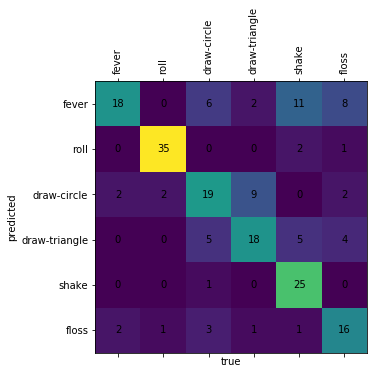

In [246]:
fig = plt.figure(figsize=(5,5))
ax = plt.subplot()

labels = list(test_df['label'].value_counts().index)

confusion = confusion_matrix(test_labels, test_pred, labels=labels)
ax.matshow(confusion)

ax.set_xticks(range(len(labels)))
ax.set_yticks(range(len(labels)))

ax.set_xticklabels(labels, rotation=90);
ax.set_yticklabels(labels);

for i in range(len(labels)):
    for j in range(len(labels)):        
        ax.text(j, i, confusion[i,j], va='center', ha='center')
        
plt.xlabel('true')
plt.ylabel('predicted')

In [193]:
print(classification_report(test_labels, test_pred, labels=labels))

               precision    recall  f1-score   support

         roll       0.91      0.84      0.87        37
        fever       0.57      0.49      0.52        35
        shake       0.71      0.83      0.76        35
draw-triangle       0.62      0.85      0.72        33
        floss       0.71      0.39      0.50        31
  draw-circle       0.56      0.64      0.60        28

    micro avg       0.68      0.68      0.68       199
    macro avg       0.68      0.67      0.66       199
 weighted avg       0.69      0.68      0.67       199



### Lets look only at the three Dance moves and see if we can get better performance. 

### Remove  simple gestures

In [194]:
df = df[df["label"]!= "shake"]
df = df[df["label"]!= "draw-triangle"]
df = df[df["label"]!="draw-circle"]

### Train test split

In [195]:
train_df, test_df = train_test_split(df, train_size=0.75)
train_df = train_df.dropna()
test_df = test_df.dropna()
print(f'train size = {train_df.shape}')
print(f'test size = {test_df.shape}')

print(train_df['label'].value_counts())
print(test_df['label'].value_counts())

train size = (292, 55)
test size = (98, 55)
roll     105
fever     96
floss     91
Name: label, dtype: int64
roll     40
fever    34
floss    24
Name: label, dtype: int64


### Train Random Forest

In [196]:
model = RandomForestClassifier(max_depth=3,min_samples_leaf=3,n_estimators=100)
    
model.fit(train_df.drop('label', axis=1), train_df['label'])

train_pred = model.predict(train_df.drop('label', axis=1))
train_labels = train_df['label']
train_acc = np.sum(train_pred==train_labels) / len(train_pred)

test_pred = model.predict(test_df.drop('label', axis=1))
test_labels = test_df['label']
test_acc = np.sum(test_pred==test_labels) / len(test_pred)

print(f'train acc = {train_acc}, test_acc = {test_acc}')

train acc = 0.9212328767123288, test_acc = 0.8775510204081632


Text(0, 0.5, 'predicted')

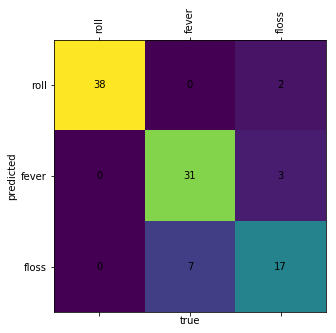

In [197]:
fig = plt.figure(figsize=(5,5))
ax = plt.subplot()

labels = list(test_df['label'].value_counts().index)

confusion = confusion_matrix(test_labels, test_pred, labels=labels)
ax.matshow(confusion)

ax.set_xticks(range(len(labels)))
ax.set_yticks(range(len(labels)))

ax.set_xticklabels(labels, rotation=90);
ax.set_yticklabels(labels);

for i in range(len(labels)):
    for j in range(len(labels)):        
        ax.text(j, i, confusion[i,j], va='center', ha='center')
        
plt.xlabel('true')
plt.ylabel('predicted')

In [198]:
print(classification_report(test_labels, test_pred, labels=labels))

              precision    recall  f1-score   support

        roll       1.00      0.95      0.97        40
       fever       0.82      0.91      0.86        34
       floss       0.77      0.71      0.74        24

   micro avg       0.88      0.88      0.88        98
   macro avg       0.86      0.86      0.86        98
weighted avg       0.88      0.88      0.88        98



In [199]:
df = pd.DataFrame(examples)
df = df[df["x_length"] > 200]
df = df.dropna()

In [200]:
train_df, test_df = train_test_split(df, train_size=0.75)

print(f'train size = {train_df.shape}')
print(f'test size = {test_df.shape}')

print(train_df['label'].value_counts())
print(test_df['label'].value_counts())

train size = (595, 55)
test size = (199, 55)
roll             108
draw-triangle    107
draw-circle      102
fever             95
shake             93
floss             90
Name: label, dtype: int64
shake            47
roll             37
fever            35
draw-triangle    28
draw-circle      27
floss            25
Name: label, dtype: int64


In [201]:
train_label = np.array(train_df['label'])
test_label = np.array(test_df['label'])

label_encoder = LabelEncoder()
one_hot_encoder = OneHotEncoder(sparse=False,categories='auto')

train_integer = label_encoder.fit_transform(train_label)
train_onehot = one_hot_encoder.fit_transform(train_integer.reshape(len(train_integer), 1))

test_integer = label_encoder.transform(test_label)
test_onehot = one_hot_encoder.transform(test_integer.reshape(len(test_integer), 1))

In [203]:
model_1 = keras.Sequential([
    keras.layers.Dense(25, activation=tf.nn.relu, input_shape=(54,)),
    keras.layers.Dense(6, activation=tf.nn.log_softmax)
]) 

In [204]:
adm = tf.train.AdamOptimizer(learning_rate=1e-3)
model_1.compile(optimizer=adm, 
              loss=tf.losses.softmax_cross_entropy,
              metrics=['accuracy'])


In [205]:
history = model_1.fit( train_df.drop('label', axis=1), train_onehot, epochs=5000, batch_size=100, verbose=1)

Epoch 1/5000
595/595 [==============================] - 0s 436us/step - loss: 198.0267 - acc: 0.2655
Epoch 2/5000
595/595 [==============================] - 0s 10us/step - loss: 163.7992 - acc: 0.2924
Epoch 3/5000
595/595 [==============================] - 0s 10us/step - loss: 133.5061 - acc: 0.2992
Epoch 4/5000
595/595 [==============================] - 0s 10us/step - loss: 104.3426 - acc: 0.3126
Epoch 5/5000
595/595 [==============================] - 0s 10us/step - loss: 81.5696 - acc: 0.2874
Epoch 6/5000
595/595 [==============================] - 0s 11us/step - loss: 66.3429 - acc: 0.3042
Epoch 7/5000
595/595 [==============================] - 0s 13us/step - loss: 54.7772 - acc: 0.3395
Epoch 8/5000
595/595 [==============================] - 0s 11us/step - loss: 45.8399 - acc: 0.3597
Epoch 9/5000
595/595 [==============================] - 0s 12us/step - loss: 37.8601 - acc: 0.4034
Epoch 10/5000
595/595 [==============================] - 0s 11us/step - loss: 32.9987 - acc: 0.4168
Epoc

595/595 [==============================] - 0s 10us/step - loss: 1.5780 - acc: 0.5832
Epoch 166/5000
595/595 [==============================] - 0s 12us/step - loss: 1.5831 - acc: 0.5966
Epoch 167/5000
595/595 [==============================] - 0s 13us/step - loss: 1.6054 - acc: 0.5714
Epoch 168/5000
595/595 [==============================] - 0s 10us/step - loss: 1.6009 - acc: 0.5748
Epoch 169/5000
595/595 [==============================] - 0s 11us/step - loss: 1.6386 - acc: 0.5630
Epoch 170/5000
595/595 [==============================] - 0s 10us/step - loss: 1.6049 - acc: 0.5882
Epoch 171/5000
595/595 [==============================] - 0s 14us/step - loss: 1.5440 - acc: 0.5933
Epoch 172/5000
595/595 [==============================] - 0s 11us/step - loss: 1.5902 - acc: 0.5798
Epoch 173/5000
595/595 [==============================] - 0s 11us/step - loss: 1.6630 - acc: 0.5647
Epoch 174/5000
595/595 [==============================] - 0s 16us/step - loss: 1.6560 - acc: 0.5613
Epoch 175/5000


595/595 [==============================] - 0s 12us/step - loss: 1.2763 - acc: 0.6067
Epoch 248/5000
595/595 [==============================] - 0s 11us/step - loss: 1.2921 - acc: 0.6118
Epoch 249/5000
595/595 [==============================] - 0s 10us/step - loss: 1.3037 - acc: 0.6050
Epoch 250/5000
595/595 [==============================] - 0s 11us/step - loss: 1.2595 - acc: 0.5933
Epoch 251/5000
595/595 [==============================] - 0s 12us/step - loss: 1.2015 - acc: 0.6218
Epoch 252/5000
595/595 [==============================] - 0s 11us/step - loss: 1.2228 - acc: 0.6101
Epoch 253/5000
595/595 [==============================] - 0s 13us/step - loss: 1.1851 - acc: 0.6218
Epoch 254/5000
595/595 [==============================] - 0s 10us/step - loss: 1.1943 - acc: 0.6101
Epoch 255/5000
595/595 [==============================] - 0s 13us/step - loss: 1.2759 - acc: 0.5899
Epoch 256/5000
595/595 [==============================] - 0s 12us/step - loss: 1.2961 - acc: 0.6168
Epoch 257/5000


595/595 [==============================] - 0s 11us/step - loss: 1.1630 - acc: 0.6353
Epoch 330/5000
595/595 [==============================] - 0s 13us/step - loss: 1.1666 - acc: 0.6202
Epoch 331/5000
595/595 [==============================] - 0s 10us/step - loss: 1.0939 - acc: 0.6403
Epoch 332/5000
595/595 [==============================] - 0s 12us/step - loss: 1.1368 - acc: 0.6269
Epoch 333/5000
595/595 [==============================] - 0s 11us/step - loss: 1.0735 - acc: 0.6252
Epoch 334/5000
595/595 [==============================] - 0s 13us/step - loss: 1.1787 - acc: 0.6303
Epoch 335/5000
595/595 [==============================] - 0s 11us/step - loss: 1.1403 - acc: 0.6050
Epoch 336/5000
595/595 [==============================] - 0s 11us/step - loss: 1.1013 - acc: 0.6437
Epoch 337/5000
595/595 [==============================] - 0s 12us/step - loss: 1.1167 - acc: 0.6303
Epoch 338/5000
595/595 [==============================] - 0s 13us/step - loss: 1.1035 - acc: 0.6437
Epoch 339/5000


595/595 [==============================] - 0s 11us/step - loss: 0.9557 - acc: 0.6655
Epoch 412/5000
595/595 [==============================] - 0s 12us/step - loss: 0.9600 - acc: 0.6739
Epoch 413/5000
595/595 [==============================] - 0s 11us/step - loss: 0.9885 - acc: 0.6655
Epoch 414/5000
595/595 [==============================] - 0s 13us/step - loss: 0.9325 - acc: 0.6857
Epoch 415/5000
595/595 [==============================] - 0s 12us/step - loss: 1.0162 - acc: 0.6319
Epoch 416/5000
595/595 [==============================] - 0s 11us/step - loss: 0.9528 - acc: 0.6639
Epoch 417/5000
595/595 [==============================] - 0s 12us/step - loss: 1.1004 - acc: 0.6370
Epoch 418/5000
595/595 [==============================] - 0s 14us/step - loss: 1.2452 - acc: 0.6134
Epoch 419/5000
595/595 [==============================] - 0s 15us/step - loss: 1.0208 - acc: 0.6454
Epoch 420/5000
595/595 [==============================] - 0s 12us/step - loss: 0.9910 - acc: 0.6756
Epoch 421/5000


595/595 [==============================] - 0s 11us/step - loss: 0.8625 - acc: 0.7042
Epoch 494/5000
595/595 [==============================] - 0s 10us/step - loss: 0.8610 - acc: 0.6790
Epoch 495/5000
595/595 [==============================] - 0s 12us/step - loss: 0.8822 - acc: 0.6723
Epoch 496/5000
595/595 [==============================] - 0s 10us/step - loss: 0.8538 - acc: 0.6941
Epoch 497/5000
595/595 [==============================] - 0s 11us/step - loss: 0.8531 - acc: 0.6857
Epoch 498/5000
595/595 [==============================] - 0s 14us/step - loss: 0.8633 - acc: 0.6807
Epoch 499/5000
595/595 [==============================] - 0s 12us/step - loss: 0.8516 - acc: 0.6756
Epoch 500/5000
595/595 [==============================] - 0s 11us/step - loss: 0.9053 - acc: 0.6756
Epoch 501/5000
595/595 [==============================] - 0s 10us/step - loss: 0.8809 - acc: 0.6739
Epoch 502/5000
595/595 [==============================] - 0s 14us/step - loss: 0.8993 - acc: 0.6891
Epoch 503/5000


595/595 [==============================] - 0s 13us/step - loss: 0.9052 - acc: 0.6773
Epoch 576/5000
595/595 [==============================] - 0s 13us/step - loss: 0.8599 - acc: 0.6857
Epoch 577/5000
595/595 [==============================] - 0s 11us/step - loss: 0.8942 - acc: 0.6739
Epoch 578/5000
595/595 [==============================] - 0s 10us/step - loss: 0.8959 - acc: 0.6824
Epoch 579/5000
595/595 [==============================] - 0s 13us/step - loss: 0.8636 - acc: 0.7008
Epoch 580/5000
595/595 [==============================] - 0s 11us/step - loss: 0.9144 - acc: 0.6807
Epoch 581/5000
595/595 [==============================] - 0s 13us/step - loss: 0.9916 - acc: 0.6504
Epoch 582/5000
595/595 [==============================] - 0s 10us/step - loss: 1.0275 - acc: 0.6487
Epoch 583/5000
595/595 [==============================] - 0s 13us/step - loss: 0.9581 - acc: 0.6672
Epoch 584/5000
595/595 [==============================] - 0s 11us/step - loss: 0.9544 - acc: 0.6639
Epoch 585/5000


595/595 [==============================] - 0s 15us/step - loss: 0.7880 - acc: 0.6958
Epoch 658/5000
595/595 [==============================] - 0s 12us/step - loss: 0.7450 - acc: 0.7227
Epoch 659/5000
595/595 [==============================] - 0s 15us/step - loss: 0.7864 - acc: 0.7008
Epoch 660/5000
595/595 [==============================] - 0s 13us/step - loss: 0.9446 - acc: 0.6723
Epoch 661/5000
595/595 [==============================] - 0s 14us/step - loss: 0.9815 - acc: 0.6471
Epoch 662/5000
595/595 [==============================] - 0s 12us/step - loss: 1.0573 - acc: 0.6639
Epoch 663/5000
595/595 [==============================] - 0s 12us/step - loss: 0.8108 - acc: 0.6975
Epoch 664/5000
595/595 [==============================] - 0s 13us/step - loss: 0.7831 - acc: 0.7025
Epoch 665/5000
595/595 [==============================] - 0s 15us/step - loss: 0.7550 - acc: 0.7160
Epoch 666/5000
595/595 [==============================] - 0s 11us/step - loss: 0.8437 - acc: 0.6773
Epoch 667/5000


595/595 [==============================] - 0s 18us/step - loss: 0.7236 - acc: 0.7328
Epoch 740/5000
595/595 [==============================] - 0s 17us/step - loss: 0.6850 - acc: 0.7395
Epoch 741/5000
595/595 [==============================] - 0s 10us/step - loss: 0.6972 - acc: 0.7395
Epoch 742/5000
595/595 [==============================] - 0s 11us/step - loss: 0.7163 - acc: 0.7328
Epoch 743/5000
595/595 [==============================] - 0s 14us/step - loss: 0.7079 - acc: 0.7277
Epoch 744/5000
595/595 [==============================] - 0s 13us/step - loss: 0.7492 - acc: 0.7193
Epoch 745/5000
595/595 [==============================] - 0s 12us/step - loss: 0.8101 - acc: 0.6891
Epoch 746/5000
595/595 [==============================] - 0s 11us/step - loss: 0.8455 - acc: 0.6487
Epoch 747/5000
595/595 [==============================] - 0s 18us/step - loss: 0.8682 - acc: 0.6807
Epoch 748/5000
595/595 [==============================] - 0s 12us/step - loss: 0.9271 - acc: 0.6790
Epoch 749/5000


595/595 [==============================] - 0s 11us/step - loss: 0.6416 - acc: 0.7462
Epoch 903/5000
595/595 [==============================] - 0s 12us/step - loss: 0.6515 - acc: 0.7429
Epoch 904/5000
595/595 [==============================] - 0s 10us/step - loss: 0.6908 - acc: 0.7513
Epoch 905/5000
595/595 [==============================] - 0s 10us/step - loss: 0.7199 - acc: 0.7361
Epoch 906/5000
595/595 [==============================] - 0s 14us/step - loss: 0.7532 - acc: 0.7244
Epoch 907/5000
595/595 [==============================] - 0s 13us/step - loss: 0.7413 - acc: 0.7227
Epoch 908/5000
595/595 [==============================] - 0s 10us/step - loss: 0.8373 - acc: 0.7025
Epoch 909/5000
595/595 [==============================] - 0s 11us/step - loss: 0.7557 - acc: 0.7160
Epoch 910/5000
595/595 [==============================] - 0s 11us/step - loss: 0.7629 - acc: 0.6941
Epoch 911/5000
595/595 [==============================] - 0s 10us/step - loss: 0.7034 - acc: 0.7311
Epoch 912/5000


595/595 [==============================] - 0s 12us/step - loss: 0.6688 - acc: 0.7513
Epoch 985/5000
595/595 [==============================] - 0s 11us/step - loss: 0.6583 - acc: 0.7429
Epoch 986/5000
595/595 [==============================] - 0s 12us/step - loss: 0.6739 - acc: 0.7513
Epoch 987/5000
595/595 [==============================] - 0s 13us/step - loss: 0.7146 - acc: 0.7328
Epoch 988/5000
595/595 [==============================] - 0s 11us/step - loss: 0.7123 - acc: 0.7412
Epoch 989/5000
595/595 [==============================] - 0s 13us/step - loss: 0.6730 - acc: 0.7546
Epoch 990/5000
595/595 [==============================] - 0s 10us/step - loss: 0.6833 - acc: 0.7294
Epoch 991/5000
595/595 [==============================] - 0s 12us/step - loss: 0.6757 - acc: 0.7479
Epoch 992/5000
595/595 [==============================] - 0s 11us/step - loss: 0.6579 - acc: 0.7429
Epoch 993/5000
595/595 [==============================] - 0s 12us/step - loss: 0.7159 - acc: 0.7345
Epoch 994/5000


595/595 [==============================] - 0s 13us/step - loss: 0.7369 - acc: 0.7227
Epoch 1147/5000
595/595 [==============================] - 0s 11us/step - loss: 0.6956 - acc: 0.7261
Epoch 1148/5000
595/595 [==============================] - 0s 14us/step - loss: 0.7197 - acc: 0.7328
Epoch 1149/5000
595/595 [==============================] - 0s 11us/step - loss: 0.6870 - acc: 0.7328
Epoch 1150/5000
595/595 [==============================] - 0s 12us/step - loss: 0.6512 - acc: 0.7546
Epoch 1151/5000
595/595 [==============================] - 0s 11us/step - loss: 0.7124 - acc: 0.7176
Epoch 1152/5000
595/595 [==============================] - 0s 13us/step - loss: 0.6944 - acc: 0.7328
Epoch 1153/5000
595/595 [==============================] - 0s 13us/step - loss: 0.6367 - acc: 0.7580
Epoch 1154/5000
595/595 [==============================] - 0s 11us/step - loss: 0.5958 - acc: 0.7765
Epoch 1155/5000
595/595 [==============================] - 0s 14us/step - loss: 0.6228 - acc: 0.7714
Epoch 

595/595 [==============================] - 0s 12us/step - loss: 0.8151 - acc: 0.6992
Epoch 1309/5000
595/595 [==============================] - 0s 12us/step - loss: 0.8997 - acc: 0.7126
Epoch 1310/5000
595/595 [==============================] - 0s 10us/step - loss: 0.7907 - acc: 0.7294
Epoch 1311/5000
595/595 [==============================] - 0s 13us/step - loss: 0.7271 - acc: 0.7261
Epoch 1312/5000
595/595 [==============================] - 0s 11us/step - loss: 0.7578 - acc: 0.7160
Epoch 1313/5000
595/595 [==============================] - 0s 13us/step - loss: 0.6720 - acc: 0.7294
Epoch 1314/5000
595/595 [==============================] - 0s 11us/step - loss: 0.7449 - acc: 0.7244
Epoch 1315/5000
595/595 [==============================] - 0s 11us/step - loss: 0.6528 - acc: 0.7429
Epoch 1316/5000
595/595 [==============================] - 0s 16us/step - loss: 0.6743 - acc: 0.7395
Epoch 1317/5000
595/595 [==============================] - 0s 13us/step - loss: 0.6608 - acc: 0.7513
Epoch 

595/595 [==============================] - 0s 13us/step - loss: 0.6113 - acc: 0.7664
Epoch 1471/5000
595/595 [==============================] - 0s 12us/step - loss: 0.6159 - acc: 0.7529
Epoch 1472/5000
595/595 [==============================] - 0s 11us/step - loss: 0.7452 - acc: 0.7261
Epoch 1473/5000
595/595 [==============================] - 0s 12us/step - loss: 0.6764 - acc: 0.7496
Epoch 1474/5000
595/595 [==============================] - 0s 10us/step - loss: 0.6275 - acc: 0.7496
Epoch 1475/5000
595/595 [==============================] - 0s 11us/step - loss: 0.6971 - acc: 0.7378
Epoch 1476/5000
595/595 [==============================] - 0s 11us/step - loss: 0.6361 - acc: 0.7445
Epoch 1477/5000
595/595 [==============================] - 0s 14us/step - loss: 0.5815 - acc: 0.7681
Epoch 1478/5000
595/595 [==============================] - 0s 11us/step - loss: 0.5952 - acc: 0.7782
Epoch 1479/5000
595/595 [==============================] - 0s 16us/step - loss: 0.6769 - acc: 0.7244
Epoch 

595/595 [==============================] - 0s 14us/step - loss: 0.5218 - acc: 0.8134
Epoch 1633/5000
595/595 [==============================] - 0s 14us/step - loss: 0.5168 - acc: 0.7916
Epoch 1634/5000
595/595 [==============================] - 0s 12us/step - loss: 0.5489 - acc: 0.7849
Epoch 1635/5000
595/595 [==============================] - 0s 12us/step - loss: 0.5413 - acc: 0.7899
Epoch 1636/5000
595/595 [==============================] - 0s 11us/step - loss: 0.5475 - acc: 0.7748
Epoch 1637/5000
595/595 [==============================] - 0s 12us/step - loss: 0.6212 - acc: 0.7882
Epoch 1638/5000
595/595 [==============================] - 0s 12us/step - loss: 0.5986 - acc: 0.7765
Epoch 1639/5000
595/595 [==============================] - 0s 11us/step - loss: 0.5786 - acc: 0.7731
Epoch 1640/5000
595/595 [==============================] - 0s 17us/step - loss: 0.5562 - acc: 0.8034
Epoch 1641/5000
595/595 [==============================] - 0s 11us/step - loss: 0.5881 - acc: 0.7882
Epoch 

595/595 [==============================] - 0s 10us/step - loss: 0.5928 - acc: 0.7731
Epoch 1795/5000
595/595 [==============================] - 0s 15us/step - loss: 0.5399 - acc: 0.7849
Epoch 1796/5000
595/595 [==============================] - 0s 12us/step - loss: 0.5513 - acc: 0.7815
Epoch 1797/5000
595/595 [==============================] - 0s 14us/step - loss: 0.5964 - acc: 0.7697
Epoch 1798/5000
595/595 [==============================] - 0s 14us/step - loss: 0.5559 - acc: 0.7899
Epoch 1799/5000
595/595 [==============================] - 0s 12us/step - loss: 0.5844 - acc: 0.7782
Epoch 1800/5000
595/595 [==============================] - 0s 11us/step - loss: 0.5589 - acc: 0.7933
Epoch 1801/5000
595/595 [==============================] - 0s 13us/step - loss: 0.6215 - acc: 0.7748
Epoch 1802/5000
595/595 [==============================] - 0s 11us/step - loss: 0.5601 - acc: 0.7832
Epoch 1803/5000
595/595 [==============================] - 0s 14us/step - loss: 0.5647 - acc: 0.7815
Epoch 

595/595 [==============================] - 0s 13us/step - loss: 0.5961 - acc: 0.7731
Epoch 1957/5000
595/595 [==============================] - 0s 15us/step - loss: 0.5567 - acc: 0.7832
Epoch 1958/5000
595/595 [==============================] - 0s 10us/step - loss: 0.5270 - acc: 0.8000
Epoch 1959/5000
595/595 [==============================] - 0s 14us/step - loss: 0.5331 - acc: 0.7950
Epoch 1960/5000
595/595 [==============================] - 0s 11us/step - loss: 0.4905 - acc: 0.8303
Epoch 1961/5000
595/595 [==============================] - 0s 12us/step - loss: 0.4807 - acc: 0.8286
Epoch 1962/5000
595/595 [==============================] - 0s 12us/step - loss: 0.4923 - acc: 0.8000
Epoch 1963/5000
595/595 [==============================] - 0s 14us/step - loss: 0.4919 - acc: 0.8101
Epoch 1964/5000
595/595 [==============================] - 0s 11us/step - loss: 0.4863 - acc: 0.8319
Epoch 1965/5000
595/595 [==============================] - 0s 12us/step - loss: 0.4897 - acc: 0.8118
Epoch 

595/595 [==============================] - 0s 10us/step - loss: 0.5538 - acc: 0.7899
Epoch 2119/5000
595/595 [==============================] - 0s 12us/step - loss: 0.6683 - acc: 0.7866
Epoch 2120/5000
595/595 [==============================] - 0s 13us/step - loss: 0.7057 - acc: 0.7445
Epoch 2121/5000
595/595 [==============================] - 0s 11us/step - loss: 0.6476 - acc: 0.7714
Epoch 2122/5000
595/595 [==============================] - 0s 10us/step - loss: 0.6728 - acc: 0.7563
Epoch 2123/5000
595/595 [==============================] - 0s 10us/step - loss: 0.5307 - acc: 0.8000
Epoch 2124/5000
595/595 [==============================] - 0s 10us/step - loss: 0.5774 - acc: 0.7882
Epoch 2125/5000
595/595 [==============================] - 0s 38us/step - loss: 0.4902 - acc: 0.8168
Epoch 2126/5000
595/595 [==============================] - 0s 31us/step - loss: 0.5365 - acc: 0.7866
Epoch 2127/5000
595/595 [==============================] - 0s 29us/step - loss: 0.5540 - acc: 0.7916
Epoch 

595/595 [==============================] - 0s 13us/step - loss: 0.5101 - acc: 0.8218
Epoch 2281/5000
595/595 [==============================] - 0s 10us/step - loss: 0.5219 - acc: 0.8252
Epoch 2282/5000
595/595 [==============================] - 0s 14us/step - loss: 0.5397 - acc: 0.8017
Epoch 2283/5000
595/595 [==============================] - 0s 11us/step - loss: 0.5551 - acc: 0.7748
Epoch 2284/5000
595/595 [==============================] - 0s 12us/step - loss: 0.5363 - acc: 0.8067
Epoch 2285/5000
595/595 [==============================] - 0s 11us/step - loss: 0.5204 - acc: 0.8084
Epoch 2286/5000
595/595 [==============================] - 0s 12us/step - loss: 0.4910 - acc: 0.8067
Epoch 2287/5000
595/595 [==============================] - 0s 12us/step - loss: 0.5161 - acc: 0.8185
Epoch 2288/5000
595/595 [==============================] - 0s 13us/step - loss: 0.4838 - acc: 0.8286
Epoch 2289/5000
595/595 [==============================] - 0s 12us/step - loss: 0.4859 - acc: 0.8185
Epoch 

595/595 [==============================] - 0s 12us/step - loss: 0.4511 - acc: 0.8353
Epoch 2443/5000
595/595 [==============================] - 0s 10us/step - loss: 0.4298 - acc: 0.8504
Epoch 2444/5000
595/595 [==============================] - 0s 12us/step - loss: 0.4572 - acc: 0.8319
Epoch 2445/5000
595/595 [==============================] - 0s 11us/step - loss: 0.4802 - acc: 0.8118
Epoch 2446/5000
595/595 [==============================] - 0s 15us/step - loss: 0.4618 - acc: 0.8319
Epoch 2447/5000
595/595 [==============================] - 0s 12us/step - loss: 0.4900 - acc: 0.8269
Epoch 2448/5000
595/595 [==============================] - 0s 13us/step - loss: 0.5394 - acc: 0.8101
Epoch 2449/5000
595/595 [==============================] - 0s 11us/step - loss: 0.4873 - acc: 0.8084
Epoch 2450/5000
595/595 [==============================] - 0s 15us/step - loss: 0.5286 - acc: 0.7832
Epoch 2451/5000
595/595 [==============================] - 0s 12us/step - loss: 0.5549 - acc: 0.7899
Epoch 

595/595 [==============================] - 0s 13us/step - loss: 0.4608 - acc: 0.8387
Epoch 2605/5000
595/595 [==============================] - 0s 15us/step - loss: 0.4388 - acc: 0.8437
Epoch 2606/5000
595/595 [==============================] - 0s 10us/step - loss: 0.4667 - acc: 0.8303
Epoch 2607/5000
595/595 [==============================] - 0s 13us/step - loss: 0.4976 - acc: 0.8303
Epoch 2608/5000
595/595 [==============================] - 0s 10us/step - loss: 0.4549 - acc: 0.8252
Epoch 2609/5000
595/595 [==============================] - 0s 13us/step - loss: 0.4729 - acc: 0.8218
Epoch 2610/5000
595/595 [==============================] - 0s 10us/step - loss: 0.4527 - acc: 0.8454
Epoch 2611/5000
595/595 [==============================] - 0s 14us/step - loss: 0.4211 - acc: 0.8471
Epoch 2612/5000
595/595 [==============================] - 0s 11us/step - loss: 0.4617 - acc: 0.8202
Epoch 2613/5000
595/595 [==============================] - 0s 11us/step - loss: 0.4413 - acc: 0.8454
Epoch 

595/595 [==============================] - 0s 15us/step - loss: 0.4800 - acc: 0.8269
Epoch 2767/5000
595/595 [==============================] - 0s 11us/step - loss: 0.4702 - acc: 0.8185
Epoch 2768/5000
595/595 [==============================] - 0s 10us/step - loss: 0.4050 - acc: 0.8471
Epoch 2769/5000
595/595 [==============================] - 0s 11us/step - loss: 0.4198 - acc: 0.8420
Epoch 2770/5000
595/595 [==============================] - 0s 13us/step - loss: 0.4379 - acc: 0.8555
Epoch 2771/5000
595/595 [==============================] - 0s 11us/step - loss: 0.4756 - acc: 0.8454
Epoch 2772/5000
595/595 [==============================] - 0s 12us/step - loss: 0.4631 - acc: 0.8353
Epoch 2773/5000
595/595 [==============================] - 0s 12us/step - loss: 0.4525 - acc: 0.8387
Epoch 2774/5000
595/595 [==============================] - 0s 11us/step - loss: 0.5178 - acc: 0.8084
Epoch 2775/5000
595/595 [==============================] - 0s 12us/step - loss: 0.4905 - acc: 0.8303
Epoch 

595/595 [==============================] - 0s 14us/step - loss: 0.4874 - acc: 0.8084
Epoch 2929/5000
595/595 [==============================] - 0s 12us/step - loss: 0.4760 - acc: 0.8017
Epoch 2930/5000
595/595 [==============================] - 0s 13us/step - loss: 0.4967 - acc: 0.8185
Epoch 2931/5000
595/595 [==============================] - 0s 10us/step - loss: 0.4818 - acc: 0.8050
Epoch 2932/5000
595/595 [==============================] - 0s 12us/step - loss: 0.4499 - acc: 0.8303
Epoch 2933/5000
595/595 [==============================] - 0s 11us/step - loss: 0.4742 - acc: 0.8134
Epoch 2934/5000
595/595 [==============================] - 0s 11us/step - loss: 0.3989 - acc: 0.8521
Epoch 2935/5000
595/595 [==============================] - 0s 14us/step - loss: 0.4113 - acc: 0.8555
Epoch 2936/5000
595/595 [==============================] - 0s 13us/step - loss: 0.3861 - acc: 0.8706
Epoch 2937/5000
595/595 [==============================] - 0s 15us/step - loss: 0.4138 - acc: 0.8521
Epoch 

595/595 [==============================] - 0s 11us/step - loss: 0.5188 - acc: 0.8134
Epoch 3091/5000
595/595 [==============================] - 0s 13us/step - loss: 0.4618 - acc: 0.8420
Epoch 3092/5000
595/595 [==============================] - 0s 14us/step - loss: 0.4603 - acc: 0.8218
Epoch 3093/5000
595/595 [==============================] - 0s 10us/step - loss: 0.4741 - acc: 0.8353
Epoch 3094/5000
595/595 [==============================] - 0s 11us/step - loss: 0.4156 - acc: 0.8487
Epoch 3095/5000
595/595 [==============================] - 0s 14us/step - loss: 0.3876 - acc: 0.8555
Epoch 3096/5000
595/595 [==============================] - 0s 14us/step - loss: 0.3751 - acc: 0.8588
Epoch 3097/5000
595/595 [==============================] - 0s 11us/step - loss: 0.3913 - acc: 0.8538
Epoch 3098/5000
595/595 [==============================] - 0s 15us/step - loss: 0.4045 - acc: 0.8504
Epoch 3099/5000
595/595 [==============================] - 0s 11us/step - loss: 0.4352 - acc: 0.8420
Epoch 

595/595 [==============================] - 0s 11us/step - loss: 0.4678 - acc: 0.8185
Epoch 3253/5000
595/595 [==============================] - 0s 10us/step - loss: 0.4683 - acc: 0.8303
Epoch 3254/5000
595/595 [==============================] - 0s 10us/step - loss: 0.4186 - acc: 0.8622
Epoch 3255/5000
595/595 [==============================] - 0s 14us/step - loss: 0.4103 - acc: 0.8437
Epoch 3256/5000
595/595 [==============================] - 0s 11us/step - loss: 0.3986 - acc: 0.8622
Epoch 3257/5000
595/595 [==============================] - 0s 11us/step - loss: 0.4276 - acc: 0.8471
Epoch 3258/5000
595/595 [==============================] - 0s 10us/step - loss: 0.4234 - acc: 0.8353
Epoch 3259/5000
595/595 [==============================] - 0s 10us/step - loss: 0.4752 - acc: 0.8286
Epoch 3260/5000
595/595 [==============================] - 0s 11us/step - loss: 0.5057 - acc: 0.8185
Epoch 3261/5000
595/595 [==============================] - 0s 12us/step - loss: 0.4873 - acc: 0.8269
Epoch 

595/595 [==============================] - 0s 12us/step - loss: 0.4420 - acc: 0.8353
Epoch 3415/5000
595/595 [==============================] - 0s 10us/step - loss: 0.3936 - acc: 0.8487
Epoch 3416/5000
595/595 [==============================] - 0s 10us/step - loss: 0.3997 - acc: 0.8622
Epoch 3417/5000
595/595 [==============================] - 0s 11us/step - loss: 0.3701 - acc: 0.8689
Epoch 3418/5000
595/595 [==============================] - 0s 11us/step - loss: 0.3868 - acc: 0.8521
Epoch 3419/5000
595/595 [==============================] - 0s 15us/step - loss: 0.3989 - acc: 0.8471
Epoch 3420/5000
595/595 [==============================] - 0s 15us/step - loss: 0.3875 - acc: 0.8689
Epoch 3421/5000
595/595 [==============================] - 0s 12us/step - loss: 0.3648 - acc: 0.8689
Epoch 3422/5000
595/595 [==============================] - 0s 10us/step - loss: 0.3654 - acc: 0.8723
Epoch 3423/5000
595/595 [==============================] - 0s 10us/step - loss: 0.4001 - acc: 0.8588
Epoch 

595/595 [==============================] - 0s 13us/step - loss: 0.4263 - acc: 0.8403
Epoch 3577/5000
595/595 [==============================] - 0s 11us/step - loss: 0.4176 - acc: 0.8387
Epoch 3578/5000
595/595 [==============================] - 0s 10us/step - loss: 0.4098 - acc: 0.8555
Epoch 3579/5000
595/595 [==============================] - 0s 10us/step - loss: 0.3869 - acc: 0.8622
Epoch 3580/5000
595/595 [==============================] - 0s 11us/step - loss: 0.4004 - acc: 0.8672
Epoch 3581/5000
595/595 [==============================] - 0s 11us/step - loss: 0.4219 - acc: 0.8353
Epoch 3582/5000
595/595 [==============================] - 0s 11us/step - loss: 0.4031 - acc: 0.8605
Epoch 3583/5000
595/595 [==============================] - 0s 13us/step - loss: 0.3884 - acc: 0.8622
Epoch 3584/5000
595/595 [==============================] - 0s 12us/step - loss: 0.4034 - acc: 0.8588
Epoch 3585/5000
595/595 [==============================] - 0s 10us/step - loss: 0.4320 - acc: 0.8252
Epoch 

595/595 [==============================] - 0s 13us/step - loss: 0.3520 - acc: 0.8790
Epoch 3739/5000
595/595 [==============================] - 0s 14us/step - loss: 0.3641 - acc: 0.8571
Epoch 3740/5000
595/595 [==============================] - 0s 13us/step - loss: 0.3867 - acc: 0.8588
Epoch 3741/5000
595/595 [==============================] - 0s 14us/step - loss: 0.3699 - acc: 0.8689
Epoch 3742/5000
595/595 [==============================] - 0s 13us/step - loss: 0.4114 - acc: 0.8555
Epoch 3743/5000
595/595 [==============================] - 0s 12us/step - loss: 0.4121 - acc: 0.8555
Epoch 3744/5000
595/595 [==============================] - 0s 13us/step - loss: 0.4989 - acc: 0.8134
Epoch 3745/5000
595/595 [==============================] - 0s 13us/step - loss: 0.4356 - acc: 0.8185
Epoch 3746/5000
595/595 [==============================] - 0s 13us/step - loss: 0.4541 - acc: 0.8319
Epoch 3747/5000
595/595 [==============================] - 0s 13us/step - loss: 0.4693 - acc: 0.8336
Epoch 

595/595 [==============================] - 0s 13us/step - loss: 0.4104 - acc: 0.8403
Epoch 3901/5000
595/595 [==============================] - 0s 10us/step - loss: 0.3615 - acc: 0.8824
Epoch 3902/5000
595/595 [==============================] - 0s 10us/step - loss: 0.3505 - acc: 0.8538
Epoch 3903/5000
595/595 [==============================] - 0s 9us/step - loss: 0.3764 - acc: 0.8571
Epoch 3904/5000
595/595 [==============================] - 0s 10us/step - loss: 0.4198 - acc: 0.8420
Epoch 3905/5000
595/595 [==============================] - 0s 11us/step - loss: 0.3962 - acc: 0.8639
Epoch 3906/5000
595/595 [==============================] - 0s 9us/step - loss: 0.3829 - acc: 0.8555
Epoch 3907/5000
595/595 [==============================] - 0s 11us/step - loss: 0.3805 - acc: 0.8504
Epoch 3908/5000
595/595 [==============================] - 0s 11us/step - loss: 0.4667 - acc: 0.8571
Epoch 3909/5000
595/595 [==============================] - 0s 10us/step - loss: 0.4895 - acc: 0.8202
Epoch 39

595/595 [==============================] - 0s 11us/step - loss: 0.3894 - acc: 0.8571
Epoch 4062/5000
595/595 [==============================] - 0s 13us/step - loss: 0.4197 - acc: 0.8370
Epoch 4063/5000
595/595 [==============================] - 0s 11us/step - loss: 0.3786 - acc: 0.8622
Epoch 4064/5000
595/595 [==============================] - 0s 14us/step - loss: 0.3737 - acc: 0.8807
Epoch 4065/5000
595/595 [==============================] - 0s 12us/step - loss: 0.3827 - acc: 0.8420
Epoch 4066/5000
595/595 [==============================] - 0s 12us/step - loss: 0.4215 - acc: 0.8639
Epoch 4067/5000
595/595 [==============================] - 0s 12us/step - loss: 0.3380 - acc: 0.8807
Epoch 4068/5000
595/595 [==============================] - 0s 15us/step - loss: 0.3757 - acc: 0.8706
Epoch 4069/5000
595/595 [==============================] - 0s 12us/step - loss: 0.3612 - acc: 0.8689
Epoch 4070/5000
595/595 [==============================] - 0s 10us/step - loss: 0.3949 - acc: 0.8689
Epoch 

595/595 [==============================] - 0s 11us/step - loss: 0.3842 - acc: 0.8555
Epoch 4224/5000
595/595 [==============================] - 0s 13us/step - loss: 0.3643 - acc: 0.8891
Epoch 4225/5000
595/595 [==============================] - 0s 10us/step - loss: 0.3490 - acc: 0.8706
Epoch 4226/5000
595/595 [==============================] - 0s 10us/step - loss: 0.3553 - acc: 0.8538
Epoch 4227/5000
595/595 [==============================] - 0s 12us/step - loss: 0.3476 - acc: 0.8824
Epoch 4228/5000
595/595 [==============================] - 0s 11us/step - loss: 0.3491 - acc: 0.8723
Epoch 4229/5000
595/595 [==============================] - 0s 14us/step - loss: 0.3508 - acc: 0.8706
Epoch 4230/5000
595/595 [==============================] - 0s 11us/step - loss: 0.3703 - acc: 0.8622
Epoch 4231/5000
595/595 [==============================] - 0s 14us/step - loss: 0.4187 - acc: 0.8471
Epoch 4232/5000
595/595 [==============================] - 0s 11us/step - loss: 0.3921 - acc: 0.8639
Epoch 

595/595 [==============================] - 0s 12us/step - loss: 0.4965 - acc: 0.8471
Epoch 4386/5000
595/595 [==============================] - 0s 11us/step - loss: 0.4588 - acc: 0.8286
Epoch 4387/5000
595/595 [==============================] - 0s 16us/step - loss: 0.3783 - acc: 0.8672
Epoch 4388/5000
595/595 [==============================] - 0s 10us/step - loss: 0.3780 - acc: 0.8756
Epoch 4389/5000
595/595 [==============================] - 0s 12us/step - loss: 0.3686 - acc: 0.8723
Epoch 4390/5000
595/595 [==============================] - 0s 13us/step - loss: 0.3723 - acc: 0.8655
Epoch 4391/5000
595/595 [==============================] - 0s 13us/step - loss: 0.3808 - acc: 0.8588
Epoch 4392/5000
595/595 [==============================] - 0s 12us/step - loss: 0.3784 - acc: 0.8622
Epoch 4393/5000
595/595 [==============================] - 0s 14us/step - loss: 0.4027 - acc: 0.8454
Epoch 4394/5000
595/595 [==============================] - 0s 16us/step - loss: 0.5068 - acc: 0.8202
Epoch 

595/595 [==============================] - 0s 10us/step - loss: 0.3532 - acc: 0.8723
Epoch 4548/5000
595/595 [==============================] - 0s 13us/step - loss: 0.3645 - acc: 0.8723
Epoch 4549/5000
595/595 [==============================] - 0s 12us/step - loss: 0.3355 - acc: 0.8756
Epoch 4550/5000
595/595 [==============================] - 0s 13us/step - loss: 0.3744 - acc: 0.8739
Epoch 4551/5000
595/595 [==============================] - 0s 12us/step - loss: 0.3586 - acc: 0.8605
Epoch 4552/5000
595/595 [==============================] - 0s 14us/step - loss: 0.3449 - acc: 0.8739
Epoch 4553/5000
595/595 [==============================] - 0s 10us/step - loss: 0.3842 - acc: 0.8487
Epoch 4554/5000
595/595 [==============================] - 0s 12us/step - loss: 0.4165 - acc: 0.8790
Epoch 4555/5000
595/595 [==============================] - 0s 13us/step - loss: 0.3457 - acc: 0.8824
Epoch 4556/5000
595/595 [==============================] - 0s 11us/step - loss: 0.3638 - acc: 0.8790
Epoch 

595/595 [==============================] - 0s 12us/step - loss: 0.3740 - acc: 0.8504
Epoch 4709/5000
595/595 [==============================] - 0s 11us/step - loss: 0.3495 - acc: 0.8807
Epoch 4710/5000
595/595 [==============================] - 0s 11us/step - loss: 0.3388 - acc: 0.8739
Epoch 4711/5000
595/595 [==============================] - 0s 15us/step - loss: 0.3368 - acc: 0.8807
Epoch 4712/5000
595/595 [==============================] - 0s 14us/step - loss: 0.3729 - acc: 0.8521
Epoch 4713/5000
595/595 [==============================] - 0s 19us/step - loss: 0.4814 - acc: 0.8168
Epoch 4714/5000
595/595 [==============================] - 0s 12us/step - loss: 0.4220 - acc: 0.8487
Epoch 4715/5000
595/595 [==============================] - 0s 16us/step - loss: 0.3871 - acc: 0.8639
Epoch 4716/5000
595/595 [==============================] - 0s 14us/step - loss: 0.3348 - acc: 0.8807
Epoch 4717/5000
595/595 [==============================] - 0s 13us/step - loss: 0.3388 - acc: 0.8739
Epoch 

595/595 [==============================] - 0s 11us/step - loss: 0.2913 - acc: 0.8992
Epoch 4870/5000
595/595 [==============================] - 0s 12us/step - loss: 0.3240 - acc: 0.8824
Epoch 4871/5000
595/595 [==============================] - 0s 13us/step - loss: 0.3378 - acc: 0.8672
Epoch 4872/5000
595/595 [==============================] - 0s 13us/step - loss: 0.3355 - acc: 0.8790
Epoch 4873/5000
595/595 [==============================] - 0s 11us/step - loss: 0.3155 - acc: 0.8706
Epoch 4874/5000
595/595 [==============================] - 0s 11us/step - loss: 0.3235 - acc: 0.8908
Epoch 4875/5000
595/595 [==============================] - 0s 14us/step - loss: 0.3379 - acc: 0.8723
Epoch 4876/5000
595/595 [==============================] - 0s 13us/step - loss: 0.3281 - acc: 0.8824
Epoch 4877/5000
595/595 [==============================] - 0s 12us/step - loss: 0.3691 - acc: 0.8773
Epoch 4878/5000
595/595 [==============================] - 0s 13us/step - loss: 0.3673 - acc: 0.8555
Epoch 

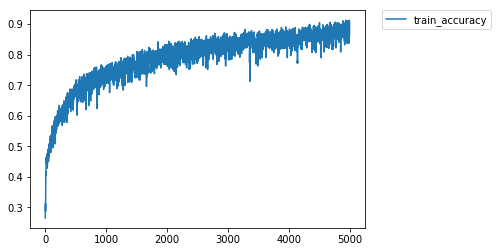

In [206]:
plt.plot(history.history['acc'], label = 'train_accuracy',)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

In [207]:
test_loss, test_acc = model_1.evaluate(test_df.drop('label', axis=1), test_onehot)

print('Test accuracy:', test_acc)

199/199 [==============================] - 0s 523us/step
Test accuracy: 0.6582914572864321


In [208]:
y_hat = model_1.predict(test_df.drop('label', axis=1))
y_hat = y_hat.argmax(axis=1)
y_hat = label_encoder.inverse_transform(y_hat)

Text(0, 0.5, 'predicted')

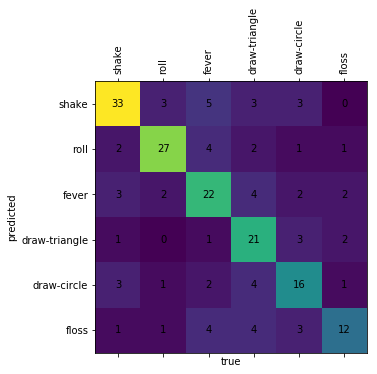

In [209]:
fig = plt.figure(figsize=(5,5))
ax = plt.subplot()

labels = list(test_df['label'].value_counts().index)

confusion = confusion_matrix(test_label, y_hat, labels=labels)
ax.matshow(confusion)

ax.set_xticks(range(len(labels)))
ax.set_yticks(range(len(labels)))

ax.set_xticklabels(labels, rotation=90);
ax.set_yticklabels(labels);

for i in range(len(labels)):
    for j in range(len(labels)):        
        ax.text(j, i, confusion[i,j], va='center', ha='center')
        
plt.xlabel('true')
plt.ylabel('predicted')

In [210]:
print(classification_report(test_label, y_hat, labels=labels))

               precision    recall  f1-score   support

        shake       0.77      0.70      0.73        47
         roll       0.79      0.73      0.76        37
        fever       0.58      0.63      0.60        35
draw-triangle       0.55      0.75      0.64        28
  draw-circle       0.57      0.59      0.58        27
        floss       0.67      0.48      0.56        25

    micro avg       0.66      0.66      0.66       199
    macro avg       0.66      0.65      0.65       199
 weighted avg       0.67      0.66      0.66       199



In [212]:
df = pd.DataFrame(examples)
df = df[df["x_length"] > 200]
df = df.dropna()
df = df[df["label"]!= "shake"]
df = df[df["label"]!= "draw-triangle"]
df = df[df["label"]!="draw-circle"]

In [213]:
train_df, test_df = train_test_split(df, train_size=0.75)

print(f'train size = {train_df.shape}')
print(f'test size = {test_df.shape}')

print(train_df['label'].value_counts())
print(test_df['label'].value_counts())

train size = (292, 55)
test size = (98, 55)
roll     118
fever     92
floss     82
Name: label, dtype: int64
fever    38
floss    33
roll     27
Name: label, dtype: int64


In [214]:
train_label = np.array(train_df['label'])
test_label = np.array(test_df['label'])

label_encoder = LabelEncoder()
one_hot_encoder = OneHotEncoder(sparse=False,categories='auto')

train_integer = label_encoder.fit_transform(train_label)
train_onehot = one_hot_encoder.fit_transform(train_integer.reshape(len(train_integer), 1))

test_integer = label_encoder.transform(test_label)
test_onehot = one_hot_encoder.transform(test_integer.reshape(len(test_integer), 1))

In [215]:
model_2 = keras.Sequential([
    keras.layers.Dense(25, activation=tf.nn.relu, input_shape=(54,)),
    keras.layers.Dense(3, activation=tf.nn.log_softmax)
]) 

In [216]:
adm = tf.train.AdamOptimizer(learning_rate=1e-3)
model_2.compile(optimizer=adm, 
              loss=tf.losses.softmax_cross_entropy,
              metrics=['accuracy'])


In [218]:
history = model_2.fit( train_df.drop('label', axis=1), train_onehot, epochs=5000, batch_size=100, verbose=1)

Epoch 1/5000
292/292 [==============================] - 0s 892us/step - loss: 216.5704 - acc: 0.2774
Epoch 2/5000
292/292 [==============================] - 0s 12us/step - loss: 179.3294 - acc: 0.2877
Epoch 3/5000
292/292 [==============================] - 0s 11us/step - loss: 147.6712 - acc: 0.2637
Epoch 4/5000
292/292 [==============================] - 0s 13us/step - loss: 123.9560 - acc: 0.2534
Epoch 5/5000
292/292 [==============================] - 0s 12us/step - loss: 104.8083 - acc: 0.2671
Epoch 6/5000
292/292 [==============================] - 0s 12us/step - loss: 90.5870 - acc: 0.2842
Epoch 7/5000
292/292 [==============================] - 0s 12us/step - loss: 79.5137 - acc: 0.3014
Epoch 8/5000
292/292 [==============================] - 0s 13us/step - loss: 71.3406 - acc: 0.3082
Epoch 9/5000
292/292 [==============================] - 0s 14us/step - loss: 64.1759 - acc: 0.2945
Epoch 10/5000
292/292 [==============================] - 0s 21us/step - loss: 58.1298 - acc: 0.2842
Epo

292/292 [==============================] - 0s 12us/step - loss: 0.6856 - acc: 0.7911
Epoch 166/5000
292/292 [==============================] - 0s 14us/step - loss: 0.6862 - acc: 0.7911
Epoch 167/5000
292/292 [==============================] - 0s 19us/step - loss: 0.6915 - acc: 0.8014
Epoch 168/5000
292/292 [==============================] - 0s 16us/step - loss: 0.6659 - acc: 0.7842
Epoch 169/5000
292/292 [==============================] - 0s 19us/step - loss: 0.6923 - acc: 0.7671
Epoch 170/5000
292/292 [==============================] - 0s 14us/step - loss: 0.6575 - acc: 0.8082
Epoch 171/5000
292/292 [==============================] - 0s 16us/step - loss: 0.6528 - acc: 0.8116
Epoch 172/5000
292/292 [==============================] - 0s 14us/step - loss: 0.6466 - acc: 0.7877
Epoch 173/5000
292/292 [==============================] - 0s 16us/step - loss: 0.6625 - acc: 0.7842
Epoch 174/5000
292/292 [==============================] - 0s 16us/step - loss: 0.7085 - acc: 0.7774
Epoch 175/5000


292/292 [==============================] - 0s 12us/step - loss: 0.4605 - acc: 0.8288
Epoch 248/5000
292/292 [==============================] - 0s 17us/step - loss: 0.4670 - acc: 0.8082
Epoch 249/5000
292/292 [==============================] - 0s 13us/step - loss: 0.4238 - acc: 0.8253
Epoch 250/5000
292/292 [==============================] - 0s 12us/step - loss: 0.4433 - acc: 0.8185
Epoch 251/5000
292/292 [==============================] - 0s 14us/step - loss: 0.4488 - acc: 0.8082
Epoch 252/5000
292/292 [==============================] - 0s 13us/step - loss: 0.4199 - acc: 0.8185
Epoch 253/5000
292/292 [==============================] - 0s 15us/step - loss: 0.4325 - acc: 0.8185
Epoch 254/5000
292/292 [==============================] - 0s 12us/step - loss: 0.4057 - acc: 0.8322
Epoch 255/5000
292/292 [==============================] - 0s 13us/step - loss: 0.4032 - acc: 0.8048
Epoch 256/5000
292/292 [==============================] - 0s 18us/step - loss: 0.4263 - acc: 0.8219
Epoch 257/5000


292/292 [==============================] - 0s 16us/step - loss: 0.3171 - acc: 0.8699
Epoch 330/5000
292/292 [==============================] - 0s 14us/step - loss: 0.3158 - acc: 0.8664
Epoch 331/5000
292/292 [==============================] - 0s 17us/step - loss: 0.2818 - acc: 0.8767
Epoch 332/5000
292/292 [==============================] - 0s 16us/step - loss: 0.3161 - acc: 0.8527
Epoch 333/5000
292/292 [==============================] - 0s 14us/step - loss: 0.3610 - acc: 0.8664
Epoch 334/5000
292/292 [==============================] - 0s 13us/step - loss: 0.3531 - acc: 0.8288
Epoch 335/5000
292/292 [==============================] - 0s 13us/step - loss: 0.4024 - acc: 0.8630
Epoch 336/5000
292/292 [==============================] - 0s 16us/step - loss: 0.3434 - acc: 0.8390
Epoch 337/5000
292/292 [==============================] - 0s 16us/step - loss: 0.3092 - acc: 0.8801
Epoch 338/5000
292/292 [==============================] - 0s 14us/step - loss: 0.2895 - acc: 0.8664
Epoch 339/5000


292/292 [==============================] - 0s 12us/step - loss: 0.2527 - acc: 0.8938
Epoch 412/5000
292/292 [==============================] - 0s 18us/step - loss: 0.2583 - acc: 0.8699
Epoch 413/5000
292/292 [==============================] - 0s 15us/step - loss: 0.2641 - acc: 0.9110
Epoch 414/5000
292/292 [==============================] - 0s 19us/step - loss: 0.2490 - acc: 0.8836
Epoch 415/5000
292/292 [==============================] - 0s 12us/step - loss: 0.2624 - acc: 0.8973
Epoch 416/5000
292/292 [==============================] - 0s 12us/step - loss: 0.2514 - acc: 0.9007
Epoch 417/5000
292/292 [==============================] - 0s 12us/step - loss: 0.2727 - acc: 0.8699
Epoch 418/5000
292/292 [==============================] - 0s 12us/step - loss: 0.2711 - acc: 0.8870
Epoch 419/5000
292/292 [==============================] - 0s 11us/step - loss: 0.2792 - acc: 0.8801
Epoch 420/5000
292/292 [==============================] - 0s 15us/step - loss: 0.2806 - acc: 0.8870
Epoch 421/5000


292/292 [==============================] - 0s 14us/step - loss: 0.2209 - acc: 0.9075
Epoch 494/5000
292/292 [==============================] - 0s 15us/step - loss: 0.2322 - acc: 0.9178
Epoch 495/5000
292/292 [==============================] - 0s 15us/step - loss: 0.2215 - acc: 0.8904
Epoch 496/5000
292/292 [==============================] - 0s 16us/step - loss: 0.2459 - acc: 0.9041
Epoch 497/5000
292/292 [==============================] - 0s 13us/step - loss: 0.2631 - acc: 0.8870
Epoch 498/5000
292/292 [==============================] - 0s 12us/step - loss: 0.2950 - acc: 0.8664
Epoch 499/5000
292/292 [==============================] - 0s 15us/step - loss: 0.2548 - acc: 0.8938
Epoch 500/5000
292/292 [==============================] - 0s 13us/step - loss: 0.2769 - acc: 0.8904
Epoch 501/5000
292/292 [==============================] - 0s 17us/step - loss: 0.2521 - acc: 0.8733
Epoch 502/5000
292/292 [==============================] - 0s 17us/step - loss: 0.3126 - acc: 0.8836
Epoch 503/5000


292/292 [==============================] - 0s 14us/step - loss: 0.2191 - acc: 0.9041
Epoch 657/5000
292/292 [==============================] - 0s 12us/step - loss: 0.2013 - acc: 0.9178
Epoch 658/5000
292/292 [==============================] - 0s 13us/step - loss: 0.2017 - acc: 0.9212
Epoch 659/5000
292/292 [==============================] - 0s 16us/step - loss: 0.1917 - acc: 0.9041
Epoch 660/5000
292/292 [==============================] - 0s 13us/step - loss: 0.2036 - acc: 0.9247
Epoch 661/5000
292/292 [==============================] - 0s 12us/step - loss: 0.2455 - acc: 0.9007
Epoch 662/5000
292/292 [==============================] - 0s 12us/step - loss: 0.2475 - acc: 0.9007
Epoch 663/5000
292/292 [==============================] - 0s 15us/step - loss: 0.2531 - acc: 0.8699
Epoch 664/5000
292/292 [==============================] - 0s 14us/step - loss: 0.3388 - acc: 0.8733
Epoch 665/5000
292/292 [==============================] - 0s 12us/step - loss: 0.3049 - acc: 0.8699
Epoch 666/5000


292/292 [==============================] - 0s 17us/step - loss: 0.1828 - acc: 0.9281
Epoch 739/5000
292/292 [==============================] - 0s 15us/step - loss: 0.2087 - acc: 0.9075
Epoch 740/5000
292/292 [==============================] - 0s 14us/step - loss: 0.2072 - acc: 0.9281
Epoch 741/5000
292/292 [==============================] - 0s 15us/step - loss: 0.1959 - acc: 0.9178
Epoch 742/5000
292/292 [==============================] - 0s 17us/step - loss: 0.1961 - acc: 0.9110
Epoch 743/5000
292/292 [==============================] - 0s 13us/step - loss: 0.1783 - acc: 0.9418
Epoch 744/5000
292/292 [==============================] - 0s 15us/step - loss: 0.1880 - acc: 0.9315
Epoch 745/5000
292/292 [==============================] - 0s 14us/step - loss: 0.1810 - acc: 0.9281
Epoch 746/5000
292/292 [==============================] - 0s 12us/step - loss: 0.1756 - acc: 0.9281
Epoch 747/5000
292/292 [==============================] - 0s 16us/step - loss: 0.1836 - acc: 0.9349
Epoch 748/5000


292/292 [==============================] - 0s 25us/step - loss: 0.1628 - acc: 0.9349
Epoch 902/5000
292/292 [==============================] - 0s 21us/step - loss: 0.1541 - acc: 0.9349
Epoch 903/5000
292/292 [==============================] - 0s 20us/step - loss: 0.1671 - acc: 0.9384
Epoch 904/5000
292/292 [==============================] - 0s 15us/step - loss: 0.1689 - acc: 0.9349
Epoch 905/5000
292/292 [==============================] - 0s 13us/step - loss: 0.1716 - acc: 0.9384
Epoch 906/5000
292/292 [==============================] - 0s 12us/step - loss: 0.1713 - acc: 0.9315
Epoch 907/5000
292/292 [==============================] - 0s 12us/step - loss: 0.1794 - acc: 0.9384
Epoch 908/5000
292/292 [==============================] - 0s 18us/step - loss: 0.1731 - acc: 0.9349
Epoch 909/5000
292/292 [==============================] - 0s 14us/step - loss: 0.1619 - acc: 0.9384
Epoch 910/5000
292/292 [==============================] - 0s 14us/step - loss: 0.1566 - acc: 0.9384
Epoch 911/5000


292/292 [==============================] - 0s 11us/step - loss: 0.1630 - acc: 0.9281
Epoch 984/5000
292/292 [==============================] - 0s 14us/step - loss: 0.1970 - acc: 0.9315
Epoch 985/5000
292/292 [==============================] - 0s 16us/step - loss: 0.1751 - acc: 0.9144
Epoch 986/5000
292/292 [==============================] - 0s 14us/step - loss: 0.1491 - acc: 0.9384
Epoch 987/5000
292/292 [==============================] - 0s 12us/step - loss: 0.1538 - acc: 0.9452
Epoch 988/5000
292/292 [==============================] - 0s 13us/step - loss: 0.1616 - acc: 0.9384
Epoch 989/5000
292/292 [==============================] - 0s 12us/step - loss: 0.1653 - acc: 0.9315
Epoch 990/5000
292/292 [==============================] - 0s 11us/step - loss: 0.1559 - acc: 0.9452
Epoch 991/5000
292/292 [==============================] - 0s 11us/step - loss: 0.1590 - acc: 0.9349
Epoch 992/5000
292/292 [==============================] - 0s 14us/step - loss: 0.1440 - acc: 0.9521
Epoch 993/5000


292/292 [==============================] - 0s 12us/step - loss: 0.1550 - acc: 0.9486
Epoch 1146/5000
292/292 [==============================] - 0s 17us/step - loss: 0.1485 - acc: 0.9452
Epoch 1147/5000
292/292 [==============================] - 0s 13us/step - loss: 0.1831 - acc: 0.9281
Epoch 1148/5000
292/292 [==============================] - 0s 17us/step - loss: 0.2060 - acc: 0.9178
Epoch 1149/5000
292/292 [==============================] - 0s 17us/step - loss: 0.1887 - acc: 0.9178
Epoch 1150/5000
292/292 [==============================] - 0s 13us/step - loss: 0.1606 - acc: 0.9315
Epoch 1151/5000
292/292 [==============================] - 0s 13us/step - loss: 0.1845 - acc: 0.9281
Epoch 1152/5000
292/292 [==============================] - 0s 14us/step - loss: 0.2339 - acc: 0.9110
Epoch 1153/5000
292/292 [==============================] - 0s 14us/step - loss: 0.1995 - acc: 0.9212
Epoch 1154/5000
292/292 [==============================] - 0s 12us/step - loss: 0.1795 - acc: 0.9281
Epoch 

292/292 [==============================] - 0s 14us/step - loss: 0.2110 - acc: 0.9075
Epoch 1308/5000
292/292 [==============================] - 0s 14us/step - loss: 0.1647 - acc: 0.9212
Epoch 1309/5000
292/292 [==============================] - 0s 14us/step - loss: 0.1578 - acc: 0.9418
Epoch 1310/5000
292/292 [==============================] - 0s 12us/step - loss: 0.1536 - acc: 0.9315
Epoch 1311/5000
292/292 [==============================] - 0s 12us/step - loss: 0.1452 - acc: 0.9521
Epoch 1312/5000
292/292 [==============================] - 0s 13us/step - loss: 0.1381 - acc: 0.9486
Epoch 1313/5000
292/292 [==============================] - 0s 16us/step - loss: 0.1390 - acc: 0.9486
Epoch 1314/5000
292/292 [==============================] - 0s 22us/step - loss: 0.1292 - acc: 0.9589
Epoch 1315/5000
292/292 [==============================] - 0s 18us/step - loss: 0.1282 - acc: 0.9555
Epoch 1316/5000
292/292 [==============================] - 0s 14us/step - loss: 0.1306 - acc: 0.9555
Epoch 

292/292 [==============================] - 0s 17us/step - loss: 0.1375 - acc: 0.9486
Epoch 1470/5000
292/292 [==============================] - 0s 16us/step - loss: 0.1246 - acc: 0.9521
Epoch 1471/5000
292/292 [==============================] - 0s 14us/step - loss: 0.1265 - acc: 0.9589
Epoch 1472/5000
292/292 [==============================] - 0s 14us/step - loss: 0.1172 - acc: 0.9555
Epoch 1473/5000
292/292 [==============================] - 0s 14us/step - loss: 0.1213 - acc: 0.9589
Epoch 1474/5000
292/292 [==============================] - 0s 14us/step - loss: 0.1182 - acc: 0.9589
Epoch 1475/5000
292/292 [==============================] - 0s 11us/step - loss: 0.1138 - acc: 0.9658
Epoch 1476/5000
292/292 [==============================] - 0s 13us/step - loss: 0.1193 - acc: 0.9555
Epoch 1477/5000
292/292 [==============================] - 0s 26us/step - loss: 0.1165 - acc: 0.9623
Epoch 1478/5000
292/292 [==============================] - 0s 15us/step - loss: 0.1082 - acc: 0.9726
Epoch 

292/292 [==============================] - 0s 15us/step - loss: 0.1441 - acc: 0.9418
Epoch 1632/5000
292/292 [==============================] - 0s 15us/step - loss: 0.1971 - acc: 0.9247
Epoch 1633/5000
292/292 [==============================] - 0s 17us/step - loss: 0.1873 - acc: 0.8938
Epoch 1634/5000
292/292 [==============================] - 0s 13us/step - loss: 0.1836 - acc: 0.9281
Epoch 1635/5000
292/292 [==============================] - 0s 15us/step - loss: 0.1364 - acc: 0.9589
Epoch 1636/5000
292/292 [==============================] - 0s 16us/step - loss: 0.1446 - acc: 0.9452
Epoch 1637/5000
292/292 [==============================] - 0s 15us/step - loss: 0.1526 - acc: 0.9452
Epoch 1638/5000
292/292 [==============================] - 0s 13us/step - loss: 0.1512 - acc: 0.9486
Epoch 1639/5000
292/292 [==============================] - 0s 17us/step - loss: 0.1316 - acc: 0.9521
Epoch 1640/5000
292/292 [==============================] - 0s 14us/step - loss: 0.1669 - acc: 0.9349
Epoch 

292/292 [==============================] - 0s 14us/step - loss: 0.1166 - acc: 0.9589
Epoch 1794/5000
292/292 [==============================] - 0s 12us/step - loss: 0.1057 - acc: 0.9623
Epoch 1795/5000
292/292 [==============================] - 0s 13us/step - loss: 0.1037 - acc: 0.9623
Epoch 1796/5000
292/292 [==============================] - 0s 12us/step - loss: 0.0972 - acc: 0.9658
Epoch 1797/5000
292/292 [==============================] - 0s 11us/step - loss: 0.0990 - acc: 0.9658
Epoch 1798/5000
292/292 [==============================] - 0s 12us/step - loss: 0.1051 - acc: 0.9726
Epoch 1799/5000
292/292 [==============================] - 0s 12us/step - loss: 0.1055 - acc: 0.9623
Epoch 1800/5000
292/292 [==============================] - 0s 12us/step - loss: 0.1039 - acc: 0.9658
Epoch 1801/5000
292/292 [==============================] - 0s 14us/step - loss: 0.0960 - acc: 0.9726
Epoch 1802/5000
292/292 [==============================] - 0s 19us/step - loss: 0.0955 - acc: 0.9760
Epoch 

292/292 [==============================] - 0s 14us/step - loss: 0.0917 - acc: 0.9726
Epoch 1956/5000
292/292 [==============================] - 0s 17us/step - loss: 0.0952 - acc: 0.9692
Epoch 1957/5000
292/292 [==============================] - 0s 15us/step - loss: 0.0985 - acc: 0.9658
Epoch 1958/5000
292/292 [==============================] - 0s 20us/step - loss: 0.0927 - acc: 0.9726
Epoch 1959/5000
292/292 [==============================] - 0s 18us/step - loss: 0.0904 - acc: 0.9760
Epoch 1960/5000
292/292 [==============================] - 0s 17us/step - loss: 0.0897 - acc: 0.9795
Epoch 1961/5000
292/292 [==============================] - 0s 14us/step - loss: 0.0971 - acc: 0.9692
Epoch 1962/5000
292/292 [==============================] - 0s 17us/step - loss: 0.1008 - acc: 0.9623
Epoch 1963/5000
292/292 [==============================] - 0s 20us/step - loss: 0.0955 - acc: 0.9692
Epoch 1964/5000
292/292 [==============================] - 0s 18us/step - loss: 0.1015 - acc: 0.9658
Epoch 

292/292 [==============================] - 0s 16us/step - loss: 0.0898 - acc: 0.9692
Epoch 2118/5000
292/292 [==============================] - 0s 15us/step - loss: 0.0929 - acc: 0.9623
Epoch 2119/5000
292/292 [==============================] - 0s 16us/step - loss: 0.1000 - acc: 0.9658
Epoch 2120/5000
292/292 [==============================] - 0s 15us/step - loss: 0.0919 - acc: 0.9658
Epoch 2121/5000
292/292 [==============================] - 0s 15us/step - loss: 0.0825 - acc: 0.9692
Epoch 2122/5000
292/292 [==============================] - 0s 12us/step - loss: 0.0916 - acc: 0.9692
Epoch 2123/5000
292/292 [==============================] - 0s 15us/step - loss: 0.0838 - acc: 0.9726
Epoch 2124/5000
292/292 [==============================] - 0s 15us/step - loss: 0.0858 - acc: 0.9726
Epoch 2125/5000
292/292 [==============================] - 0s 17us/step - loss: 0.0823 - acc: 0.9760
Epoch 2126/5000
292/292 [==============================] - 0s 14us/step - loss: 0.0877 - acc: 0.9760
Epoch 

292/292 [==============================] - 0s 14us/step - loss: 0.1328 - acc: 0.9589
Epoch 2280/5000
292/292 [==============================] - 0s 15us/step - loss: 0.1097 - acc: 0.9521
Epoch 2281/5000
292/292 [==============================] - 0s 12us/step - loss: 0.1110 - acc: 0.9555
Epoch 2282/5000
292/292 [==============================] - 0s 11us/step - loss: 0.0809 - acc: 0.9692
Epoch 2283/5000
292/292 [==============================] - 0s 14us/step - loss: 0.0914 - acc: 0.9692
Epoch 2284/5000
292/292 [==============================] - 0s 17us/step - loss: 0.1023 - acc: 0.9555
Epoch 2285/5000
292/292 [==============================] - 0s 15us/step - loss: 0.1040 - acc: 0.9555
Epoch 2286/5000
292/292 [==============================] - 0s 14us/step - loss: 0.1306 - acc: 0.9521
Epoch 2287/5000
292/292 [==============================] - 0s 13us/step - loss: 0.1289 - acc: 0.9555
Epoch 2288/5000
292/292 [==============================] - 0s 11us/step - loss: 0.2317 - acc: 0.9349
Epoch 

292/292 [==============================] - 0s 11us/step - loss: 0.0987 - acc: 0.9623
Epoch 2442/5000
292/292 [==============================] - 0s 11us/step - loss: 0.0936 - acc: 0.9623
Epoch 2443/5000
292/292 [==============================] - 0s 12us/step - loss: 0.0912 - acc: 0.9623
Epoch 2444/5000
292/292 [==============================] - 0s 11us/step - loss: 0.0876 - acc: 0.9658
Epoch 2445/5000
292/292 [==============================] - 0s 10us/step - loss: 0.1076 - acc: 0.9555
Epoch 2446/5000
292/292 [==============================] - 0s 11us/step - loss: 0.1051 - acc: 0.9452
Epoch 2447/5000
292/292 [==============================] - 0s 12us/step - loss: 0.1065 - acc: 0.9589
Epoch 2448/5000
292/292 [==============================] - 0s 15us/step - loss: 0.1047 - acc: 0.9555
Epoch 2449/5000
292/292 [==============================] - 0s 12us/step - loss: 0.1213 - acc: 0.9555
Epoch 2450/5000
292/292 [==============================] - 0s 11us/step - loss: 0.1047 - acc: 0.9555
Epoch 

292/292 [==============================] - 0s 11us/step - loss: 0.0851 - acc: 0.9623
Epoch 2604/5000
292/292 [==============================] - 0s 11us/step - loss: 0.0749 - acc: 0.9726
Epoch 2605/5000
292/292 [==============================] - 0s 13us/step - loss: 0.1112 - acc: 0.9555
Epoch 2606/5000
292/292 [==============================] - 0s 13us/step - loss: 0.1166 - acc: 0.9555
Epoch 2607/5000
292/292 [==============================] - 0s 11us/step - loss: 0.0938 - acc: 0.9658
Epoch 2608/5000
292/292 [==============================] - 0s 20us/step - loss: 0.0915 - acc: 0.9658
Epoch 2609/5000
292/292 [==============================] - 0s 16us/step - loss: 0.0894 - acc: 0.9658
Epoch 2610/5000
292/292 [==============================] - 0s 13us/step - loss: 0.0777 - acc: 0.9692
Epoch 2611/5000
292/292 [==============================] - 0s 12us/step - loss: 0.0861 - acc: 0.9658
Epoch 2612/5000
292/292 [==============================] - 0s 15us/step - loss: 0.0759 - acc: 0.9760
Epoch 

292/292 [==============================] - 0s 13us/step - loss: 0.0777 - acc: 0.9726
Epoch 2765/5000
292/292 [==============================] - 0s 14us/step - loss: 0.0688 - acc: 0.9726
Epoch 2766/5000
292/292 [==============================] - 0s 12us/step - loss: 0.0719 - acc: 0.9760
Epoch 2767/5000
292/292 [==============================] - 0s 18us/step - loss: 0.0772 - acc: 0.9692
Epoch 2768/5000
292/292 [==============================] - 0s 14us/step - loss: 0.0695 - acc: 0.9760
Epoch 2769/5000
292/292 [==============================] - 0s 12us/step - loss: 0.0722 - acc: 0.9760
Epoch 2770/5000
292/292 [==============================] - 0s 12us/step - loss: 0.0685 - acc: 0.9760
Epoch 2771/5000
292/292 [==============================] - 0s 15us/step - loss: 0.0639 - acc: 0.9829
Epoch 2772/5000
292/292 [==============================] - 0s 13us/step - loss: 0.0665 - acc: 0.9760
Epoch 2773/5000
292/292 [==============================] - 0s 11us/step - loss: 0.0702 - acc: 0.9829
Epoch 

292/292 [==============================] - 0s 11us/step - loss: 0.0695 - acc: 0.9692
Epoch 2927/5000
292/292 [==============================] - 0s 12us/step - loss: 0.0770 - acc: 0.9726
Epoch 2928/5000
292/292 [==============================] - 0s 10us/step - loss: 0.0742 - acc: 0.9658
Epoch 2929/5000
292/292 [==============================] - 0s 21us/step - loss: 0.0790 - acc: 0.9726
Epoch 2930/5000
292/292 [==============================] - 0s 13us/step - loss: 0.0720 - acc: 0.9726
Epoch 2931/5000
292/292 [==============================] - 0s 14us/step - loss: 0.0689 - acc: 0.9726
Epoch 2932/5000
292/292 [==============================] - 0s 12us/step - loss: 0.0642 - acc: 0.9795
Epoch 2933/5000
292/292 [==============================] - 0s 14us/step - loss: 0.0739 - acc: 0.9760
Epoch 2934/5000
292/292 [==============================] - 0s 13us/step - loss: 0.0770 - acc: 0.9623
Epoch 2935/5000
292/292 [==============================] - 0s 16us/step - loss: 0.0657 - acc: 0.9829
Epoch 

292/292 [==============================] - 0s 15us/step - loss: 0.1237 - acc: 0.9589
Epoch 3089/5000
292/292 [==============================] - 0s 15us/step - loss: 0.1023 - acc: 0.9486
Epoch 3090/5000
292/292 [==============================] - 0s 11us/step - loss: 0.1203 - acc: 0.9486
Epoch 3091/5000
292/292 [==============================] - 0s 12us/step - loss: 0.1026 - acc: 0.9555
Epoch 3092/5000
292/292 [==============================] - 0s 12us/step - loss: 0.0731 - acc: 0.9726
Epoch 3093/5000
292/292 [==============================] - 0s 12us/step - loss: 0.0789 - acc: 0.9726
Epoch 3094/5000
292/292 [==============================] - 0s 18us/step - loss: 0.0753 - acc: 0.9795
Epoch 3095/5000
292/292 [==============================] - 0s 18us/step - loss: 0.0754 - acc: 0.9726
Epoch 3096/5000
292/292 [==============================] - 0s 16us/step - loss: 0.0702 - acc: 0.9795
Epoch 3097/5000
292/292 [==============================] - 0s 14us/step - loss: 0.0724 - acc: 0.9760
Epoch 

292/292 [==============================] - 0s 12us/step - loss: 0.1168 - acc: 0.9555
Epoch 3251/5000
292/292 [==============================] - 0s 15us/step - loss: 0.0743 - acc: 0.9760
Epoch 3252/5000
292/292 [==============================] - 0s 19us/step - loss: 0.0722 - acc: 0.9760
Epoch 3253/5000
292/292 [==============================] - 0s 16us/step - loss: 0.0897 - acc: 0.9589
Epoch 3254/5000
292/292 [==============================] - 0s 13us/step - loss: 0.0854 - acc: 0.9658
Epoch 3255/5000
292/292 [==============================] - 0s 14us/step - loss: 0.0848 - acc: 0.9692
Epoch 3256/5000
292/292 [==============================] - 0s 17us/step - loss: 0.0756 - acc: 0.9726
Epoch 3257/5000
292/292 [==============================] - 0s 13us/step - loss: 0.0776 - acc: 0.9658
Epoch 3258/5000
292/292 [==============================] - 0s 13us/step - loss: 0.0803 - acc: 0.9726
Epoch 3259/5000
292/292 [==============================] - 0s 13us/step - loss: 0.1370 - acc: 0.9452
Epoch 

292/292 [==============================] - 0s 19us/step - loss: 0.0762 - acc: 0.9623
Epoch 3412/5000
292/292 [==============================] - 0s 12us/step - loss: 0.0556 - acc: 0.9829
Epoch 3413/5000
292/292 [==============================] - 0s 11us/step - loss: 0.0684 - acc: 0.9726
Epoch 3414/5000
292/292 [==============================] - 0s 16us/step - loss: 0.0531 - acc: 0.9829
Epoch 3415/5000
292/292 [==============================] - 0s 16us/step - loss: 0.0637 - acc: 0.9795
Epoch 3416/5000
292/292 [==============================] - 0s 15us/step - loss: 0.0638 - acc: 0.9795
Epoch 3417/5000
292/292 [==============================] - 0s 14us/step - loss: 0.0624 - acc: 0.9829
Epoch 3418/5000
292/292 [==============================] - 0s 14us/step - loss: 0.0645 - acc: 0.9726
Epoch 3419/5000
292/292 [==============================] - 0s 13us/step - loss: 0.0590 - acc: 0.9829
Epoch 3420/5000
292/292 [==============================] - 0s 13us/step - loss: 0.0666 - acc: 0.9760
Epoch 

292/292 [==============================] - 0s 13us/step - loss: 0.1411 - acc: 0.9555
Epoch 3574/5000
292/292 [==============================] - 0s 13us/step - loss: 0.2871 - acc: 0.9281
Epoch 3575/5000
292/292 [==============================] - 0s 17us/step - loss: 0.3998 - acc: 0.8904
Epoch 3576/5000
292/292 [==============================] - 0s 17us/step - loss: 0.3173 - acc: 0.9315
Epoch 3577/5000
292/292 [==============================] - 0s 13us/step - loss: 0.3005 - acc: 0.9178
Epoch 3578/5000
292/292 [==============================] - 0s 17us/step - loss: 0.1805 - acc: 0.9521
Epoch 3579/5000
292/292 [==============================] - 0s 14us/step - loss: 0.1971 - acc: 0.9384
Epoch 3580/5000
292/292 [==============================] - 0s 14us/step - loss: 0.2565 - acc: 0.9178
Epoch 3581/5000
292/292 [==============================] - 0s 14us/step - loss: 0.1196 - acc: 0.9349
Epoch 3582/5000
292/292 [==============================] - 0s 12us/step - loss: 0.1678 - acc: 0.9349
Epoch 

292/292 [==============================] - 0s 11us/step - loss: 0.0509 - acc: 0.9897
Epoch 3736/5000
292/292 [==============================] - 0s 11us/step - loss: 0.0519 - acc: 0.9795
Epoch 3737/5000
292/292 [==============================] - 0s 15us/step - loss: 0.0600 - acc: 0.9658
Epoch 3738/5000
292/292 [==============================] - 0s 14us/step - loss: 0.0615 - acc: 0.9795
Epoch 3739/5000
292/292 [==============================] - 0s 12us/step - loss: 0.0612 - acc: 0.9726
Epoch 3740/5000
292/292 [==============================] - 0s 11us/step - loss: 0.0495 - acc: 0.9897
Epoch 3741/5000
292/292 [==============================] - 0s 12us/step - loss: 0.0678 - acc: 0.9726
Epoch 3742/5000
292/292 [==============================] - 0s 14us/step - loss: 0.0541 - acc: 0.9726
Epoch 3743/5000
292/292 [==============================] - 0s 13us/step - loss: 0.0722 - acc: 0.9795
Epoch 3744/5000
292/292 [==============================] - 0s 12us/step - loss: 0.0799 - acc: 0.9589
Epoch 

292/292 [==============================] - 0s 17us/step - loss: 0.0514 - acc: 0.9863
Epoch 3897/5000
292/292 [==============================] - 0s 16us/step - loss: 0.0479 - acc: 0.9829
Epoch 3898/5000
292/292 [==============================] - 0s 15us/step - loss: 0.0520 - acc: 0.9829
Epoch 3899/5000
292/292 [==============================] - 0s 16us/step - loss: 0.0487 - acc: 0.9863
Epoch 3900/5000
292/292 [==============================] - 0s 17us/step - loss: 0.0519 - acc: 0.9795
Epoch 3901/5000
292/292 [==============================] - 0s 15us/step - loss: 0.0481 - acc: 0.9829
Epoch 3902/5000
292/292 [==============================] - 0s 14us/step - loss: 0.0545 - acc: 0.9795
Epoch 3903/5000
292/292 [==============================] - 0s 15us/step - loss: 0.0505 - acc: 0.9829
Epoch 3904/5000
292/292 [==============================] - 0s 13us/step - loss: 0.0508 - acc: 0.9829
Epoch 3905/5000
292/292 [==============================] - 0s 18us/step - loss: 0.0494 - acc: 0.9829
Epoch 

292/292 [==============================] - 0s 13us/step - loss: 0.1131 - acc: 0.9589
Epoch 4059/5000
292/292 [==============================] - 0s 14us/step - loss: 0.1136 - acc: 0.9452
Epoch 4060/5000
292/292 [==============================] - 0s 29us/step - loss: 0.0817 - acc: 0.9658
Epoch 4061/5000
292/292 [==============================] - 0s 15us/step - loss: 0.0879 - acc: 0.9726
Epoch 4062/5000
292/292 [==============================] - 0s 14us/step - loss: 0.0861 - acc: 0.9658
Epoch 4063/5000
292/292 [==============================] - 0s 18us/step - loss: 0.0870 - acc: 0.9589
Epoch 4064/5000
292/292 [==============================] - 0s 14us/step - loss: 0.0779 - acc: 0.9726
Epoch 4065/5000
292/292 [==============================] - 0s 14us/step - loss: 0.0806 - acc: 0.9589
Epoch 4066/5000
292/292 [==============================] - 0s 14us/step - loss: 0.1012 - acc: 0.9658
Epoch 4067/5000
292/292 [==============================] - 0s 17us/step - loss: 0.1011 - acc: 0.9589
Epoch 

292/292 [==============================] - 0s 14us/step - loss: 0.0443 - acc: 0.9897
Epoch 4220/5000
292/292 [==============================] - 0s 13us/step - loss: 0.0456 - acc: 0.9897
Epoch 4221/5000
292/292 [==============================] - 0s 16us/step - loss: 0.0439 - acc: 0.9897
Epoch 4222/5000
292/292 [==============================] - 0s 17us/step - loss: 0.0439 - acc: 0.9897
Epoch 4223/5000
292/292 [==============================] - 0s 18us/step - loss: 0.0451 - acc: 0.9829
Epoch 4224/5000
292/292 [==============================] - 0s 15us/step - loss: 0.0433 - acc: 0.9932
Epoch 4225/5000
292/292 [==============================] - 0s 14us/step - loss: 0.0475 - acc: 0.9795
Epoch 4226/5000
292/292 [==============================] - 0s 12us/step - loss: 0.0486 - acc: 0.9897
Epoch 4227/5000
292/292 [==============================] - 0s 12us/step - loss: 0.0713 - acc: 0.9589
Epoch 4228/5000
292/292 [==============================] - 0s 17us/step - loss: 0.0614 - acc: 0.9829
Epoch 

292/292 [==============================] - 0s 16us/step - loss: 0.0541 - acc: 0.9760
Epoch 4382/5000
292/292 [==============================] - 0s 15us/step - loss: 0.0540 - acc: 0.9795
Epoch 4383/5000
292/292 [==============================] - 0s 15us/step - loss: 0.0518 - acc: 0.9760
Epoch 4384/5000
292/292 [==============================] - 0s 17us/step - loss: 0.0668 - acc: 0.9658
Epoch 4385/5000
292/292 [==============================] - 0s 16us/step - loss: 0.0852 - acc: 0.9658
Epoch 4386/5000
292/292 [==============================] - 0s 15us/step - loss: 0.0700 - acc: 0.9726
Epoch 4387/5000
292/292 [==============================] - 0s 22us/step - loss: 0.0595 - acc: 0.9760
Epoch 4388/5000
292/292 [==============================] - 0s 14us/step - loss: 0.0515 - acc: 0.9863
Epoch 4389/5000
292/292 [==============================] - 0s 15us/step - loss: 0.0572 - acc: 0.9829
Epoch 4390/5000
292/292 [==============================] - 0s 15us/step - loss: 0.0611 - acc: 0.9658
Epoch 

292/292 [==============================] - 0s 18us/step - loss: 0.0767 - acc: 0.9760
Epoch 4544/5000
292/292 [==============================] - 0s 18us/step - loss: 0.0809 - acc: 0.9692
Epoch 4545/5000
292/292 [==============================] - 0s 18us/step - loss: 0.0558 - acc: 0.9760
Epoch 4546/5000
292/292 [==============================] - 0s 15us/step - loss: 0.0638 - acc: 0.9726
Epoch 4547/5000
292/292 [==============================] - 0s 15us/step - loss: 0.0482 - acc: 0.9795
Epoch 4548/5000
292/292 [==============================] - 0s 16us/step - loss: 0.0473 - acc: 0.9829
Epoch 4549/5000
292/292 [==============================] - 0s 15us/step - loss: 0.0429 - acc: 0.9863
Epoch 4550/5000
292/292 [==============================] - 0s 15us/step - loss: 0.0487 - acc: 0.9829
Epoch 4551/5000
292/292 [==============================] - 0s 14us/step - loss: 0.0537 - acc: 0.9760
Epoch 4552/5000
292/292 [==============================] - 0s 20us/step - loss: 0.0540 - acc: 0.9863
Epoch 

292/292 [==============================] - 0s 14us/step - loss: 0.0448 - acc: 0.9760
Epoch 4706/5000
292/292 [==============================] - 0s 12us/step - loss: 0.0525 - acc: 0.9863
Epoch 4707/5000
292/292 [==============================] - 0s 14us/step - loss: 0.0567 - acc: 0.9658
Epoch 4708/5000
292/292 [==============================] - 0s 16us/step - loss: 0.0686 - acc: 0.9692
Epoch 4709/5000
292/292 [==============================] - 0s 13us/step - loss: 0.0768 - acc: 0.9726
Epoch 4710/5000
292/292 [==============================] - 0s 11us/step - loss: 0.0669 - acc: 0.9760
Epoch 4711/5000
292/292 [==============================] - 0s 14us/step - loss: 0.0717 - acc: 0.9589
Epoch 4712/5000
292/292 [==============================] - 0s 14us/step - loss: 0.0560 - acc: 0.9863
Epoch 4713/5000
292/292 [==============================] - 0s 12us/step - loss: 0.0665 - acc: 0.9658
Epoch 4714/5000
292/292 [==============================] - 0s 13us/step - loss: 0.0696 - acc: 0.9692
Epoch 

292/292 [==============================] - 0s 16us/step - loss: 0.0382 - acc: 0.9897
Epoch 4868/5000
292/292 [==============================] - 0s 15us/step - loss: 0.0387 - acc: 0.9932
Epoch 4869/5000
292/292 [==============================] - 0s 15us/step - loss: 0.0383 - acc: 0.9932
Epoch 4870/5000
292/292 [==============================] - 0s 14us/step - loss: 0.0387 - acc: 0.9932
Epoch 4871/5000
292/292 [==============================] - 0s 13us/step - loss: 0.0370 - acc: 0.9932
Epoch 4872/5000
292/292 [==============================] - 0s 14us/step - loss: 0.0417 - acc: 0.9863
Epoch 4873/5000
292/292 [==============================] - 0s 18us/step - loss: 0.0443 - acc: 0.9760
Epoch 4874/5000
292/292 [==============================] - 0s 18us/step - loss: 0.0362 - acc: 0.9932
Epoch 4875/5000
292/292 [==============================] - 0s 18us/step - loss: 0.0418 - acc: 0.9932
Epoch 4876/5000
292/292 [==============================] - 0s 17us/step - loss: 0.0426 - acc: 0.9863
Epoch 

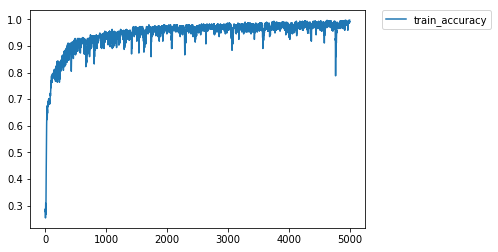

In [219]:
plt.plot(history.history['acc'], label = 'train_accuracy',)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

In [221]:
test_loss, test_acc = model_2.evaluate(test_df.drop('label', axis=1), test_onehot)

print('Test accuracy:', test_acc)

98/98 [==============================] - 0s 1ms/step
Test accuracy: 0.7755102040816326


In [223]:
y_hat = model_2.predict(test_df.drop('label', axis=1))
y_hat = y_hat.argmax(axis=1)
y_hat = label_encoder.inverse_transform(y_hat)

Text(0, 0.5, 'predicted')

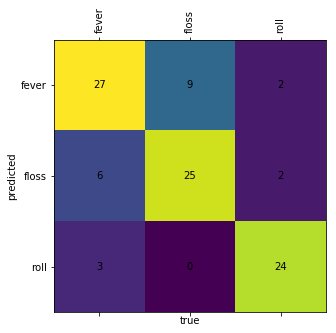

In [224]:
fig = plt.figure(figsize=(5,5))
ax = plt.subplot()

labels = list(test_df['label'].value_counts().index)

confusion = confusion_matrix(test_label, y_hat, labels=labels)
ax.matshow(confusion)

ax.set_xticks(range(len(labels)))
ax.set_yticks(range(len(labels)))

ax.set_xticklabels(labels, rotation=90);
ax.set_yticklabels(labels);

for i in range(len(labels)):
    for j in range(len(labels)):        
        ax.text(j, i, confusion[i,j], va='center', ha='center')
        
plt.xlabel('true')
plt.ylabel('predicted')

In [225]:
print(classification_report(test_label, y_hat, labels=labels))

              precision    recall  f1-score   support

       fever       0.75      0.71      0.73        38
       floss       0.74      0.76      0.75        33
        roll       0.86      0.89      0.87        27

   micro avg       0.78      0.78      0.78        98
   macro avg       0.78      0.79      0.78        98
weighted avg       0.77      0.78      0.77        98



In [123]:
# Parameter tuneing: # of hidden nodes
acc = []

for i in range(3,50,1):

    model = keras.Sequential([
        keras.layers.Dense(i, activation=tf.nn.relu, input_shape=(54,)),
        keras.layers.Dense(3, activation=tf.nn.log_softmax)
    ]) 
    adm = tf.train.AdamOptimizer(learning_rate=1e-3)
    model.compile(optimizer=adm, 
                  loss=tf.losses.softmax_cross_entropy,
                  metrics=['accuracy'])

    history = model.fit( train_df.drop('label', axis=1), train_onehot, epochs=5000, batch_size=100, verbose=0)
    test_loss, test_acc = model.evaluate(test_df.drop('label', axis=1), test_onehot)
    acc.append((i,test_acc))
    print('Test accuracy:', test_acc,i)



98/98 [==============================] - 0s 3ms/step
Test accuracy: 0.40816326530612246 3
98/98 [==============================] - 0s 3ms/step
Test accuracy: 0.3673469387755102 4
98/98 [==============================] - 0s 3ms/step
Test accuracy: 0.7346938775510204 5
98/98 [==============================] - 0s 3ms/step
Test accuracy: 0.6530612244897959 6
98/98 [==============================] - 0s 3ms/step
Test accuracy: 0.7653061224489796 7
98/98 [==============================] - 0s 3ms/step
Test accuracy: 0.7142857142857143 8
98/98 [==============================] - 0s 4ms/step
Test accuracy: 0.8163265306122449 9
98/98 [==============================] - 0s 4ms/step
Test accuracy: 0.7653061224489796 10
98/98 [==============================] - 0s 4ms/step
Test accuracy: 0.7755102040816326 11
98/98 [==============================] - 0s 4ms/step
Test accuracy: 0.7857142857142857 12
98/98 [==============================] - 0s 4ms/step
Test accuracy: 0.7857142857142857 13
98/98 [=========

In [124]:
x = [i[0] for i in acc]
y = [i[1] for i in acc]

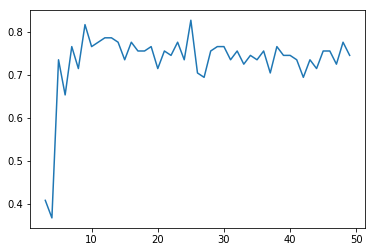

In [125]:
plt.plot(x,y)

In [127]:
# Parameter tune: # of hidden nodes 
#Same as above but with 100k epochs (2x above)

acc = []

for i in range(3,50,1):

    model = keras.Sequential([
        keras.layers.Dense(i, activation=tf.nn.relu, input_shape=(54,)),
        keras.layers.Dense(3, activation=tf.nn.log_softmax)
    ]) 
    adm = tf.train.AdamOptimizer(learning_rate=1e-3)
    model.compile(optimizer=adm, 
                  loss=tf.losses.softmax_cross_entropy,
                  metrics=['accuracy'])

    history = model.fit( train_df.drop('label', axis=1), train_onehot, epochs=10000, batch_size=100, verbose=0)
    test_loss, test_acc = model.evaluate(test_df.drop('label', axis=1), test_onehot)
    acc.append((i,test_acc))
    print('Test accuracy:', test_acc,i)


98/98 [==============================] - 1s 12ms/step
Test accuracy: 0.3673469387755102 3
98/98 [==============================] - 1s 11ms/step
Test accuracy: 0.3673469387755102 4
98/98 [==============================] - 1s 12ms/step
Test accuracy: 0.7857142857142857 5
98/98 [==============================] - 1s 12ms/step
Test accuracy: 0.7448979591836735 6
98/98 [==============================] - 1s 12ms/step
Test accuracy: 0.7755102040816326 7
98/98 [==============================] - 1s 12ms/step
Test accuracy: 0.7551020408163265 8
98/98 [==============================] - 1s 12ms/step
Test accuracy: 0.673469387755102 9
98/98 [==============================] - 1s 12ms/step
Test accuracy: 0.7551020408163265 10
98/98 [==============================] - 1s 12ms/step
Test accuracy: 0.7755102040816326 11
98/98 [==============================] - 1s 12ms/step
Test accuracy: 0.7346938775510204 12
98/98 [==============================] - 1s 13ms/step
Test accuracy: 0.7653061224489796 13
98/98 [

In [128]:
x = [i[0] for i in acc]
y = [i[1] for i in acc]

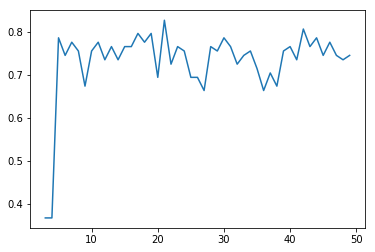

In [129]:
plt.plot(x,y)

In [137]:
# Parameter tune: # of hidden nodes in second layer with drop out
# Adding a layer and tuning second layer

acc = []

for i in range(3,50,1):

    model = keras.Sequential([
        keras.layers.Dense(25, activation=tf.nn.relu, input_shape=(54,)),
        keras.layers.Dropout(0.50),
        keras.layers.Dense(i, activation=tf.nn.relu),
        keras.layers.Dense(3, activation=tf.nn.log_softmax)
    ]) 

    adm = tf.train.AdamOptimizer(learning_rate=1e-3)

    model.compile(optimizer=adm, 
                  loss=tf.losses.softmax_cross_entropy,
                  metrics=['accuracy'])

    history = model.fit( train_df.drop('label', axis=1), train_onehot, epochs=5000, batch_size=100, verbose=0)

    test_loss, test_acc = model.evaluate(test_df.drop('label', axis=1), test_onehot)

    acc.append((i,test_acc))

    print('Test accuracy:', test_acc,i)


98/98 [==============================] - 2s 19ms/step
Test accuracy: 0.7653061224489796 3
98/98 [==============================] - 2s 19ms/step
Test accuracy: 0.3673469387755102 4
98/98 [==============================] - 2s 19ms/step
Test accuracy: 0.7755102040816326 5
98/98 [==============================] - 2s 20ms/step
Test accuracy: 0.7448979591836735 6
98/98 [==============================] - 2s 20ms/step
Test accuracy: 0.7448979591836735 7
98/98 [==============================] - 2s 21ms/step
Test accuracy: 0.7551020408163265 8
98/98 [==============================] - 2s 20ms/step
Test accuracy: 0.7244897959183674 9
98/98 [==============================] - 2s 21ms/step
Test accuracy: 0.6530612244897959 10
98/98 [==============================] - 2s 21ms/step
Test accuracy: 0.8163265306122449 11
98/98 [==============================] - 2s 21ms/step
Test accuracy: 0.7551020408163265 12
98/98 [==============================] - 2s 23ms/step
Test accuracy: 0.7959183673469388 13
98/98 

In [226]:
# Parameter tune: # of hidden nodes in second layer without drop out


acc = []

for i in range(3,50,1):

    model_nd = keras.Sequential([
        keras.layers.Dense(25, activation=tf.nn.relu, input_shape=(54,)),
        keras.layers.Dense(i, activation=tf.nn.relu),
        keras.layers.Dense(3, activation=tf.nn.log_softmax)
    ]) 

    adm = tf.train.AdamOptimizer(learning_rate=1e-3)

    model_nd.compile(optimizer=adm, 
                  loss=tf.losses.softmax_cross_entropy,
                  metrics=['accuracy'])

    history = model_nd.fit( train_df.drop('label', axis=1), train_onehot, epochs=5000, batch_size=100, verbose=0)

    test_loss, test_acc = model_nd.evaluate(test_df.drop('label', axis=1), test_onehot)

    acc.append((i,test_acc))

    print('Test accuracy:', test_acc,i)

98/98 [==============================] - 0s 1ms/step
Test accuracy: 0.6428571428571429 3
98/98 [==============================] - 0s 1ms/step
Test accuracy: 0.2857142857142857 4
98/98 [==============================] - 0s 1ms/step
Test accuracy: 0.5510204081632653 5
98/98 [==============================] - 0s 1ms/step
Test accuracy: 0.2653061224489796 6
98/98 [==============================] - 0s 1ms/step
Test accuracy: 0.2755102040816326 7
98/98 [==============================] - 0s 2ms/step
Test accuracy: 0.7244897959183674 8
98/98 [==============================] - 0s 2ms/step
Test accuracy: 0.7551020408163265 9
98/98 [==============================] - 0s 2ms/step
Test accuracy: 0.7040816326530612 10
98/98 [==============================] - 0s 2ms/step
Test accuracy: 0.7040816326530612 11
98/98 [==============================] - 0s 2ms/step
Test accuracy: 0.6428571428571429 12
98/98 [==============================] - 0s 2ms/step
Test accuracy: 0.6938775510204082 13
98/98 [==========

In [227]:
model_save_1 = keras.Sequential([
    keras.layers.Dense(25, activation=tf.nn.relu, input_shape=(54,)),
    keras.layers.Dense(3, activation=tf.nn.log_softmax)
]) 


In [229]:
adm = tf.train.AdamOptimizer(learning_rate=1e-3)

model_save_1.compile(optimizer=adm, 
              loss=tf.losses.softmax_cross_entropy,
              metrics=['accuracy'])

history = model_save_1.fit( train_df.drop('label', axis=1), train_onehot, epochs=5000, batch_size=100, verbose=0)

test_loss, test_acc = model_save_1.evaluate(test_df.drop('label', axis=1), test_onehot)

print('Test accuracy:', test_acc)

98/98 [==============================] - 1s 7ms/step
Test accuracy: 0.826530612244898


In [231]:
y_hat = model_save_1.predict(test_df.drop('label', axis=1))
y_hat = y_hat.argmax(axis=1)
y_hat = label_encoder.inverse_transform(y_hat)

Text(0, 0.5, 'predicted')

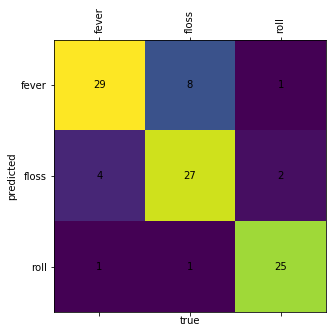

In [232]:
fig = plt.figure(figsize=(5,5))
ax = plt.subplot()

labels = list(test_df['label'].value_counts().index)

confusion = confusion_matrix(test_label, y_hat, labels=labels)
ax.matshow(confusion)

ax.set_xticks(range(len(labels)))
ax.set_yticks(range(len(labels)))

ax.set_xticklabels(labels, rotation=90);
ax.set_yticklabels(labels);

for i in range(len(labels)):
    for j in range(len(labels)):        
        ax.text(j, i, confusion[i,j], va='center', ha='center')
        
plt.xlabel('true')
plt.ylabel('predicted')

In [233]:
print(classification_report(test_label, y_hat, labels=labels))

              precision    recall  f1-score   support

       fever       0.85      0.76      0.81        38
       floss       0.75      0.82      0.78        33
        roll       0.89      0.93      0.91        27

   micro avg       0.83      0.83      0.83        98
   macro avg       0.83      0.84      0.83        98
weighted avg       0.83      0.83      0.83        98



In [237]:
import os
from pathlib import Path
from datetime import datetime as dt

save =  True 
ver = int(dt.now().timestamp())

if save:
    for fmt in ['pb', 'hdf5','json']:
        # save model as hdf5
        MODEL_DIR = f"model_save_1_82_acc/{fmt}"
        export_path = Path(MODEL_DIR, str(ver))

        if fmt == 'pb':
            # simple_save cannot handle existing repository
            !rm -r {export_path}

            # Inspired by https://www.tensorflow.org/serving/tutorials/Serving_REST_simple
            # to save model for TF-serving
            tf.saved_model.simple_save(
                tf.keras.backend.get_session(),
                str(export_path),
                inputs={'input_data': model_save_1.input},
                outputs={t.name:t for t in model_save_1.outputs})
            
        elif fmt == 'hdf5':
            # make sure directory exists
            os.makedirs(export_path, exist_ok=True)
            
            model_path = Path(export_path, 'saved_model.h5') 
            
            # hdf5
            model_save_1.save(model_path)
            
        else:
            # make sure directory exists
            os.makedirs(export_path, exist_ok=True)
            
            # json
            model_spec_path = Path(
                export_path, 'saved_model_spec.json'
            )
            model_weights_path = Path(
                export_path, str(time.time()))
            
            model_spec_path.write_text(model_save_1.to_json(), encoding='utf-8')
            model_save_1.save_weights(str(model_weights_path))

        print('\nSaved model:')
        !ls -l {export_path}

rm: cannot remove ‘model_save_1_82_acc/pb/1553723474’: No such file or directory
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: model_save_1_82_acc/pb/1553723474/saved_model.pb

Saved model:
total 7740
-rw-rw-r--. 1 mcliffor mcliffor 7922119 Mar 27 14:51 saved_model.pb
drwxr-xr-x. 2 mcliffor mcliffor    1024 Mar 27 14:51 variables

Saved model:
total 20
-rw-rw-r--. 1 mcliffor mcliffor 19896 Mar 27 14:51 saved_model.h5

Saved model:
total 31
-rw-rw-r--. 1 mcliffor mcliffor 22094 Mar 27 14:51 1553723480.1636646.data-00000-of-00001
-rw-rw-r--. 1 mcliffor mcliffor  1307 Mar 27 14:51 1553723480.1636646.index
-rw-rw-r--. 1 mcliffor mcliffor    93 Mar 27 14:51 checkpoint
-rw-rw-r--. 1 mcliffor mcliffor  1185 Mar 27 14:51 saved_model_spec.json


<a id='p2'></a>

# PART 2  EVEN MORE FEATURES 

Including the orientation data into our feature vector as well

In [7]:
def get_acceleration_and_orientation_data(df):
    re_arranged = []

    for row_index in range(len(Data)):

        x = [i[0] for i in df.iloc[row_index].motion]
        y = [i[1] for i in df.iloc[row_index].motion]
        z = [i[2] for i in df.iloc[row_index].motion]
        alpha = [i[0] for i in df.iloc[row_index].orientation]
        beta = [i[1] for i in df.iloc[row_index].orientation]
        gamma = [i[2] for i in df.iloc[row_index].orientation]
        gesture = df.iloc[row_index].gesture

        entry = [x, y, z, alpha, beta, gamma, gesture]
        re_arranged.append(entry)

    return pd.DataFrame(re_arranged, columns=["x","y","z","alpha","beta","gamma","gesture"])
    

In [8]:
B_Data = get_acceleration_and_orientation_data(Data)

In [9]:
B_Data.head()

,x,y,z,alpha,beta,gamma,gesture
0,[-2.81642],[-1.5614],[-0.97788],"[4.80787, 4.9188, 5.01804, 5.19668, 5.35103, 5...","[58.10896, 58.14502, 58.16093, 58.13456, 58.09...","[3.73614, 3.55983, 3.40379, 3.30659, 3.34045, ...",draw-circle
1,[],[],[],[356.09812],[1.66279],[0.76053],draw-circle
2,"[-12.9809, -9.46868, -7.03652, -1.59082, 3.899...","[-0.25897, 2.06525, 2.58216, 2.63155, 5.70526,...","[-3.26403, 2.20641, 1.93823, 0.49455, 0.03454,...","[292.22698, 293.36602, 294.28615, 296.80541, 3...","[44.09249, 47.86599, 50.20802, 55.35808, 60.31...","[70.54411, 66.27621, 63.97681, 58.69824, 52.34...",draw-circle
3,"[-12.07461, -13.27306, -13.26743, -13.59856, -...","[5.23257, 3.18079, 1.95103, -0.26545, -2.32471...","[-2.98558, -3.0077, -2.87265, -3.36066, -3.861...","[86.49483, 83.0223, 78.5032, 71.22467, 65.6595...","[78.62768, 76.71674, 74.86027, 72.5298, 70.964...","[-29.91469, -27.4213, -24.19585, -19.08307, -1...",draw-circle
4,"[-25.44857, -20.52717, -17.96698, -11.55767, -...","[16.63419, 18.51876, 19.80735, 22.16157, 23.56...","[-0.50768, -2.50973, -3.60222, -4.9406, -5.633...","[254.3068, 260.4193, 268.19214, 273.62494, 278...","[112.12048, 110.68234, 109.026, 107.92859, 107...","[86.17615, 78.62521, 68.34764, 60.79341, 53.85...",draw-circle


In [12]:
then = time.time()
examples = [] 
b = np.arange(1,100,10)
columns = ["x","y","z","alpha","beta","gamma"]
for i in B_Data.index:
    example = featurize(B_Data.iloc[i], b,columns)
    examples.append(example)
    
print((time.time()-then)/60,"minutes")
    

0.04726287126541138 minutes


In [13]:
examples[0]

{'x_mean_over_median': 1.0,
 'x_std_over_median': -0.0,
 'x_length': 1,
 'x_kurtosis': -3.0,
 'x_binfrac_0': 0.0,
 'x_binfrac_1': 0.0,
 'x_binfrac_2': 0.0,
 'x_binfrac_3': 0.0,
 'x_binfrac_4': 0.0,
 'x_binfrac_5': 1.0,
 'x_binfrac_6': 0.0,
 'x_binfrac_7': 0.0,
 'x_binfrac_8': 0.0,
 'x_binfrac_9': 0.0,
 'x_mean_over_median_before': nan,
 'x_mean_over_median_after': 1.0,
 'x_max_power': 0,
 'x_period': 0,
 'y_mean_over_median': 1.0,
 'y_std_over_median': -0.0,
 'y_length': 1,
 'y_kurtosis': -3.0,
 'y_binfrac_0': 0.0,
 'y_binfrac_1': 0.0,
 'y_binfrac_2': 0.0,
 'y_binfrac_3': 0.0,
 'y_binfrac_4': 0.0,
 'y_binfrac_5': 1.0,
 'y_binfrac_6': 0.0,
 'y_binfrac_7': 0.0,
 'y_binfrac_8': 0.0,
 'y_binfrac_9': 0.0,
 'y_mean_over_median_before': nan,
 'y_mean_over_median_after': 1.0,
 'y_max_power': 0,
 'y_period': 0,
 'z_mean_over_median': 1.0,
 'z_std_over_median': -0.0,
 'z_length': 1,
 'z_kurtosis': -3.0,
 'z_binfrac_0': 0.0,
 'z_binfrac_1': 0.0,
 'z_binfrac_2': 0.0,
 'z_binfrac_3': 0.0,
 'z_binfr

In [14]:
bf = pd.DataFrame(examples)

In [15]:
bf.head()

,alpha_binfrac_0,alpha_binfrac_1,alpha_binfrac_2,alpha_binfrac_3,alpha_binfrac_4,alpha_binfrac_5,alpha_binfrac_6,alpha_binfrac_7,alpha_binfrac_8,alpha_binfrac_9,...,z_binfrac_8,z_binfrac_9,z_kurtosis,z_length,z_max_power,z_mean_over_median,z_mean_over_median_after,z_mean_over_median_before,z_period,z_std_over_median
0,0.057143,0.038095,0.028571,0.028571,0.038095,0.047619,0.180952,0.133333,0.152381,0.295238,...,0.000000,0.000000,-3.000000,1,0.000000,1.000000,1.000000,NaN,0.000000,-0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,0,0.000000,NaN,NaN,NaN,0.000000,NaN
2,0.246231,0.060302,0.125628,0.000000,0.000000,0.000000,0.000000,0.040201,0.070352,0.457286,...,0.000000,0.018519,4.993345,108,68.193646,1.810502,-0.961406,4.582409,0.868056,12.248929
3,0.304762,0.228571,0.142857,0.023810,0.000000,0.000000,0.000000,0.028571,0.080952,0.190476,...,0.252381,0.190476,-0.652763,210,399.433046,1.239221,1.298908,1.179534,0.208333,-0.777379
4,0.205742,0.047847,0.000000,0.000000,0.000000,0.014354,0.066986,0.200957,0.253589,0.210526,...,0.274112,0.116751,-0.180958,197,291.249978,1.214303,0.520251,1.915438,0.190355,-1.124748


In [16]:
# Remove samples that are too small
bf = bf[bf["x_length"] > 200]

In [17]:
len(bf)

794

In [19]:
train_bf, test_bf = train_test_split(bf, train_size=0.75)
train_bf = train_bf.dropna()
test_bf = test_bf.dropna()
print(f'train size = {train_bf.shape}')
print(f'test size = {test_bf.shape}')

print(train_bf['label'].value_counts())
print(test_bf['label'].value_counts())

train size = (595, 109)
test size = (199, 109)
draw-triangle    113
roll             107
draw-circle       97
shake             96
fever             94
floss             88
Name: label, dtype: int64
shake            44
roll             38
fever            36
draw-circle      32
floss            27
draw-triangle    22
Name: label, dtype: int64


In [21]:
model = RandomForestClassifier(max_depth=3,min_samples_leaf=3,n_estimators=100)
    
model.fit(train_bf.drop('label', axis=1), train_bf['label'])

train_pred = model.predict(train_bf.drop('label', axis=1))
train_labels = train_bf['label']
train_acc = np.sum(train_pred==train_labels) / len(train_pred)

test_pred = model.predict(test_bf.drop('label', axis=1))
test_labels = test_bf['label']
test_acc = np.sum(test_pred==test_labels) / len(test_pred)

print(f'train acc = {train_acc}, test_acc = {test_acc}')

train acc = 0.7899159663865546, test_acc = 0.7437185929648241


Text(0, 0.5, 'predicted')

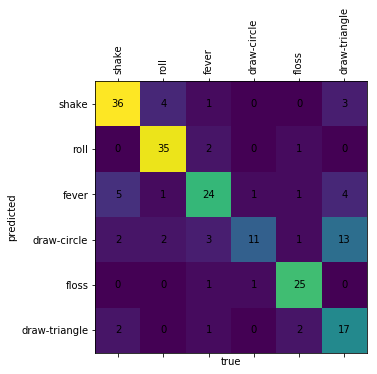

In [24]:
fig = plt.figure(figsize=(5,5))
ax = plt.subplot()

labels = list(test_bf['label'].value_counts().index)

confusion = confusion_matrix(test_labels, test_pred, labels=labels)
ax.matshow(confusion)

ax.set_xticks(range(len(labels)))
ax.set_yticks(range(len(labels)))

ax.set_xticklabels(labels, rotation=90);
ax.set_yticklabels(labels);

for i in range(len(labels)):
    for j in range(len(labels)):        
        ax.text(j, i, confusion[i,j], va='center', ha='center')
        
plt.xlabel('true')
plt.ylabel('predicted')

In [25]:
print(classification_report(test_labels, test_pred, labels=labels))

               precision    recall  f1-score   support

        shake       0.80      0.82      0.81        44
         roll       0.83      0.92      0.88        38
        fever       0.75      0.67      0.71        36
  draw-circle       0.85      0.34      0.49        32
        floss       0.83      0.93      0.88        27
draw-triangle       0.46      0.77      0.58        22

    micro avg       0.74      0.74      0.74       199
    macro avg       0.75      0.74      0.72       199
 weighted avg       0.77      0.74      0.73       199



In [26]:
bf = bf[bf["label"]!= "shake"]
bf = bf[bf["label"]!= "draw-triangle"]
bf = bf[bf["label"]!="draw-circle"]

In [32]:
train_bf, test_bf = train_test_split(bf, train_size=0.75)
train_bf = train_bf.dropna()
test_bf = test_bf.dropna()
print(f'train size = {train_bf.shape}')
print(f'test size = {test_bf.shape}')

print(train_bf['label'].value_counts())
print(test_bf['label'].value_counts())

train size = (292, 109)
test size = (98, 109)
roll     107
fever    105
floss     80
Name: label, dtype: int64
roll     38
floss    35
fever    25
Name: label, dtype: int64


In [33]:
model = RandomForestClassifier(max_depth=3,min_samples_leaf=3,n_estimators=100)
    
model.fit(train_bf.drop('label', axis=1), train_bf['label'])

train_pred = model.predict(train_bf.drop('label', axis=1))
train_labels = train_bf['label']
train_acc = np.sum(train_pred==train_labels) / len(train_pred)

test_pred = model.predict(test_bf.drop('label', axis=1))
test_labels = test_bf['label']
test_acc = np.sum(test_pred==test_labels) / len(test_pred)

print(f'train acc = {train_acc}, test_acc = {test_acc}')

train acc = 0.934931506849315, test_acc = 0.8979591836734694


Text(0, 0.5, 'predicted')

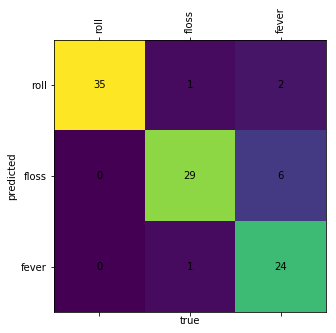

In [34]:
fig = plt.figure(figsize=(5,5))
ax = plt.subplot()

labels = list(test_bf['label'].value_counts().index)

confusion = confusion_matrix(test_labels, test_pred, labels=labels)
ax.matshow(confusion)

ax.set_xticks(range(len(labels)))
ax.set_yticks(range(len(labels)))

ax.set_xticklabels(labels, rotation=90);
ax.set_yticklabels(labels);

for i in range(len(labels)):
    for j in range(len(labels)):        
        ax.text(j, i, confusion[i,j], va='center', ha='center')
        
plt.xlabel('true')
plt.ylabel('predicted')

In [35]:
print(classification_report(test_labels, test_pred, labels=labels))

              precision    recall  f1-score   support

        roll       1.00      0.92      0.96        38
       floss       0.94      0.83      0.88        35
       fever       0.75      0.96      0.84        25

   micro avg       0.90      0.90      0.90        98
   macro avg       0.90      0.90      0.89        98
weighted avg       0.91      0.90      0.90        98



In [54]:
bf = pd.DataFrame(examples)
bf = bf[bf["x_length"] > 200]

train_bf, test_bf = train_test_split(bf, train_size=0.75)
train_bf = train_bf.dropna()
test_bf = test_bf.dropna()

print(f'train size = {train_bf.shape}')
print(f'test size = {test_bf.shape}')

print(train_bf['label'].value_counts())
print(test_bf['label'].value_counts())

train size = (595, 109)
test size = (199, 109)
roll             114
shake            102
fever            101
draw-triangle     97
draw-circle       96
floss             85
Name: label, dtype: int64
shake            38
draw-triangle    38
draw-circle      33
roll             31
floss            30
fever            29
Name: label, dtype: int64


In [55]:
train_label = np.array(train_bf['label'])
test_label = np.array(test_bf['label'])

label_encoder = LabelEncoder()
one_hot_encoder = OneHotEncoder(sparse=False,categories='auto')

train_integer = label_encoder.fit_transform(train_label)
train_onehot = one_hot_encoder.fit_transform(train_integer.reshape(len(train_integer), 1))

test_integer = label_encoder.transform(test_label)
test_onehot = one_hot_encoder.transform(test_integer.reshape(len(test_integer), 1))

In [57]:
model = keras.Sequential([
    keras.layers.Dense(100, activation=tf.nn.relu, input_shape=(108,)),
    keras.layers.Dense(6, activation=tf.nn.log_softmax)
]) 

In [58]:
adm = tf.train.AdamOptimizer(learning_rate=1e-3)
model.compile(optimizer=adm, 
              loss=tf.losses.softmax_cross_entropy,
              metrics=['accuracy'])


In [59]:
history = model.fit( train_bf.drop('label', axis=1), train_onehot, epochs=5000, batch_size=100, verbose=0)

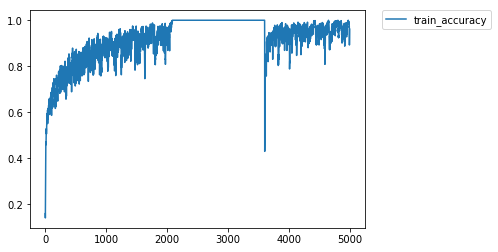

In [60]:
plt.plot(history.history['acc'], label = 'train_accuracy',)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

In [61]:
test_loss, test_acc = model.evaluate(test_bf.drop('label', axis=1), test_onehot)

print('Test accuracy:', test_acc)

199/199 [==============================] - 0s 233us/step
Test accuracy: 0.5326633174814771


In [62]:
bf = bf[bf["label"]!= "shake"]
bf = bf[bf["label"]!= "draw-triangle"]
bf = bf[bf["label"]!="draw-circle"]

In [63]:
train_bf, test_bf = train_test_split(bf, train_size=0.75)
train_bf = train_bf.dropna()
test_bf = test_bf.dropna()
print(f'train size = {train_bf.shape}')
print(f'test size = {test_bf.shape}')

print(train_bf['label'].value_counts())
print(test_bf['label'].value_counts())

train size = (292, 109)
test size = (98, 109)
roll     110
fever    101
floss     81
Name: label, dtype: int64
roll     35
floss    34
fever    29
Name: label, dtype: int64


In [64]:
train_label = np.array(train_bf['label'])
test_label = np.array(test_bf['label'])

label_encoder = LabelEncoder()
one_hot_encoder = OneHotEncoder(sparse=False,categories='auto')

train_integer = label_encoder.fit_transform(train_label)
train_onehot = one_hot_encoder.fit_transform(train_integer.reshape(len(train_integer), 1))

test_integer = label_encoder.transform(test_label)
test_onehot = one_hot_encoder.transform(test_integer.reshape(len(test_integer), 1))

In [85]:
model = keras.Sequential([
    keras.layers.Dense(8, activation=tf.nn.relu, input_shape=(108,)),
    keras.layers.Dense(3, activation=tf.nn.log_softmax)
]) 

In [86]:
adm = tf.train.AdamOptimizer(learning_rate=1e-3)
model.compile(optimizer=adm, 
              loss=tf.losses.softmax_cross_entropy,
              metrics=['accuracy'])


In [87]:
history = model.fit( train_bf.drop('label', axis=1), train_onehot, epochs=5000, batch_size=100, verbose=0)

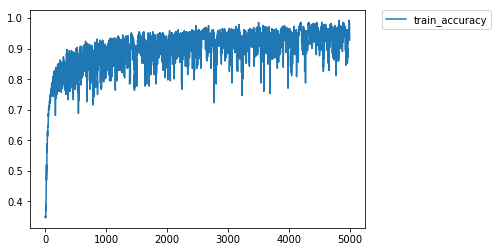

In [88]:
plt.plot(history.history['acc'], label = 'train_accuracy',)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

In [89]:
test_loss, test_acc = model.evaluate(test_bf.drop('label', axis=1), test_onehot)

print('Test accuracy:', test_acc)

98/98 [==============================] - 0s 693us/step
Test accuracy: 0.6938775510204082


### Maybe our feature vector is too long. Lets try to use PCA then predict

In [153]:
bf = pd.DataFrame(examples)
bf = bf[bf["x_length"] > 200]
bf = bf.dropna()

In [154]:
bf.head()

,alpha_binfrac_0,alpha_binfrac_1,alpha_binfrac_2,alpha_binfrac_3,alpha_binfrac_4,alpha_binfrac_5,alpha_binfrac_6,alpha_binfrac_7,alpha_binfrac_8,alpha_binfrac_9,...,z_binfrac_8,z_binfrac_9,z_kurtosis,z_length,z_max_power,z_mean_over_median,z_mean_over_median_after,z_mean_over_median_before,z_period,z_std_over_median
3,0.304762,0.228571,0.142857,0.023810,0.000000,0.000000,0.000000,0.028571,0.080952,0.190476,...,0.252381,0.190476,-0.652763,210,399.433046,1.239221,1.298908,1.179534,0.208333,-0.777379
8,0.090476,0.385714,0.028571,0.109524,0.042857,0.057143,0.066667,0.100000,0.085714,0.033333,...,0.042857,0.014286,-0.510035,210,102.597592,1.070724,0.947085,1.194362,0.327381,-1.371795
10,0.100304,0.115502,0.069909,0.185410,0.133739,0.316109,0.015198,0.000000,0.000000,0.063830,...,0.009494,0.009494,0.404437,316,298.907591,1.081910,0.582513,1.581306,0.098892,-1.597350
11,0.211604,0.054608,0.000000,0.000000,0.000000,0.000000,0.109215,0.116041,0.119454,0.389078,...,0.399194,0.205645,1.438242,248,326.302064,9.665959,9.798920,9.532998,0.075605,-20.871393
12,0.096970,0.021212,0.000000,0.000000,0.000000,0.033333,0.196970,0.330303,0.206061,0.115152,...,0.036364,0.015152,-0.200423,330,911.142382,-4.354719,-3.505882,-5.203557,0.113636,-25.922308


In [155]:
from sklearn.decomposition import PCA
pca = PCA(n_components=15)
pca.fit(bf.drop('label', axis=1))

PCA(copy=True, iterated_power='auto', n_components=15, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [156]:
pdf = pd.DataFrame(pca.transform(bf.drop('label', axis=1)), columns=['PCA%i' % i for i in range(15)], index=bf.index)

In [159]:
x = pdf.values #returns a numpy array
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
pdf = pd.DataFrame(x_scaled, index=pdf.index)

In [160]:
pdf["label"] = bf.label

In [161]:
pdf.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,label
3,0.017399,0.081295,0.326533,0.129035,0.406414,0.695013,0.120098,0.417662,0.218319,0.484349,0.368773,0.405705,0.316703,0.310173,0.349042,draw-circle
8,0.024739,0.061659,0.450668,0.076403,0.421571,0.356909,0.143879,0.416700,0.209017,0.486888,0.362474,0.401941,0.311126,0.329117,0.343599,draw-circle
10,0.011499,0.146928,0.367189,0.147979,0.417688,0.266778,0.139548,0.418155,0.291055,0.384931,0.530851,0.411439,0.311419,0.229790,0.354488,draw-circle
11,0.020633,0.248796,0.282004,0.086768,0.466889,0.245783,0.140649,0.420931,0.186591,0.492100,0.366772,0.401119,0.313298,0.194317,0.363929,draw-circle
12,0.082917,0.099936,0.660522,0.204720,0.482146,0.250167,0.150063,0.415692,0.227772,0.487173,0.363868,0.400322,0.309090,0.304713,0.347647,draw-circle


In [162]:
pdf = pdf[pdf["label"]!= "shake"]
pdf = pdf[pdf["label"]!= "draw-triangle"]
pdf = pdf[pdf["label"]!="draw-circle"]

In [163]:
train_pdf, test_pdf = train_test_split(pdf, train_size=0.75)
print(f'train size = {train_pdf.shape}')
print(f'test size = {test_pdf.shape}')

print(train_pdf['label'].value_counts())
print(test_pdf['label'].value_counts())

train size = (292, 16)
test size = (98, 16)
roll     114
fever     94
floss     84
Name: label, dtype: int64
fever    36
roll     31
floss    31
Name: label, dtype: int64


In [164]:
train_label = np.array(train_pdf['label'])
test_label = np.array(test_pdf['label'])

label_encoder = LabelEncoder()
one_hot_encoder = OneHotEncoder(sparse=False,categories='auto')

train_integer = label_encoder.fit_transform(train_label)
train_onehot = one_hot_encoder.fit_transform(train_integer.reshape(len(train_integer), 1))

test_integer = label_encoder.transform(test_label)
test_onehot = one_hot_encoder.transform(test_integer.reshape(len(test_integer), 1))

In [168]:
model = keras.Sequential([
    keras.layers.Dense(10, activation=tf.nn.relu, input_shape=(15,)),
    keras.layers.Dense(3, activation=tf.nn.log_softmax)
]) 

In [169]:
adm = tf.train.AdamOptimizer(learning_rate=1e-3)
model.compile(optimizer=adm, 
              loss=tf.losses.softmax_cross_entropy,
              metrics=['accuracy'])

In [170]:
history = model.fit( train_pdf.drop('label', axis=1), train_onehot, epochs=5000, batch_size=100, verbose=1)

Epoch 1/5000
292/292 [==============================] - 0s 849us/step - loss: 1.1694 - acc: 0.2877
Epoch 2/5000
292/292 [==============================] - 0s 11us/step - loss: 1.1558 - acc: 0.2877
Epoch 3/5000
292/292 [==============================] - 0s 10us/step - loss: 1.1449 - acc: 0.2877
Epoch 4/5000
292/292 [==============================] - 0s 10us/step - loss: 1.1336 - acc: 0.2877
Epoch 5/5000
292/292 [==============================] - 0s 11us/step - loss: 1.1237 - acc: 0.2877
Epoch 6/5000
292/292 [==============================] - 0s 10us/step - loss: 1.1145 - acc: 0.2877
Epoch 7/5000
292/292 [==============================] - 0s 11us/step - loss: 1.1066 - acc: 0.2877
Epoch 8/5000
292/292 [==============================] - 0s 11us/step - loss: 1.0996 - acc: 0.2945
Epoch 9/5000
292/292 [==============================] - 0s 11us/step - loss: 1.0930 - acc: 0.3048
Epoch 10/5000
292/292 [==============================] - 0s 19us/step - loss: 1.0873 - acc: 0.3459
Epoch 11/5000
292/

292/292 [==============================] - 0s 13us/step - loss: 0.7642 - acc: 0.7123
Epoch 165/5000
292/292 [==============================] - 0s 11us/step - loss: 0.7624 - acc: 0.7123
Epoch 166/5000
292/292 [==============================] - 0s 11us/step - loss: 0.7608 - acc: 0.7123
Epoch 167/5000
292/292 [==============================] - 0s 10us/step - loss: 0.7590 - acc: 0.7158
Epoch 168/5000
292/292 [==============================] - 0s 11us/step - loss: 0.7576 - acc: 0.7226
Epoch 169/5000
292/292 [==============================] - 0s 16us/step - loss: 0.7562 - acc: 0.7158
Epoch 170/5000
292/292 [==============================] - 0s 14us/step - loss: 0.7542 - acc: 0.7158
Epoch 171/5000
292/292 [==============================] - 0s 17us/step - loss: 0.7526 - acc: 0.7295
Epoch 172/5000
292/292 [==============================] - 0s 14us/step - loss: 0.7510 - acc: 0.7260
Epoch 173/5000
292/292 [==============================] - 0s 12us/step - loss: 0.7494 - acc: 0.7226
Epoch 174/5000


292/292 [==============================] - 0s 12us/step - loss: 0.6577 - acc: 0.7466
Epoch 247/5000
292/292 [==============================] - 0s 15us/step - loss: 0.6565 - acc: 0.7432
Epoch 248/5000
292/292 [==============================] - 0s 15us/step - loss: 0.6556 - acc: 0.7432
Epoch 249/5000
292/292 [==============================] - 0s 14us/step - loss: 0.6549 - acc: 0.7432
Epoch 250/5000
292/292 [==============================] - 0s 13us/step - loss: 0.6537 - acc: 0.7432
Epoch 251/5000
292/292 [==============================] - 0s 12us/step - loss: 0.6530 - acc: 0.7466
Epoch 252/5000
292/292 [==============================] - 0s 12us/step - loss: 0.6520 - acc: 0.7432
Epoch 253/5000
292/292 [==============================] - 0s 13us/step - loss: 0.6509 - acc: 0.7432
Epoch 254/5000
292/292 [==============================] - 0s 20us/step - loss: 0.6501 - acc: 0.7466
Epoch 255/5000
292/292 [==============================] - 0s 17us/step - loss: 0.6491 - acc: 0.7466
Epoch 256/5000


292/292 [==============================] - 0s 15us/step - loss: 0.5994 - acc: 0.7705
Epoch 329/5000
292/292 [==============================] - 0s 14us/step - loss: 0.5991 - acc: 0.7705
Epoch 330/5000
292/292 [==============================] - 0s 17us/step - loss: 0.5986 - acc: 0.7671
Epoch 331/5000
292/292 [==============================] - 0s 14us/step - loss: 0.5980 - acc: 0.7671
Epoch 332/5000
292/292 [==============================] - 0s 12us/step - loss: 0.5974 - acc: 0.7671
Epoch 333/5000
292/292 [==============================] - 0s 14us/step - loss: 0.5970 - acc: 0.7671
Epoch 334/5000
292/292 [==============================] - 0s 12us/step - loss: 0.5964 - acc: 0.7671
Epoch 335/5000
292/292 [==============================] - 0s 13us/step - loss: 0.5964 - acc: 0.7705
Epoch 336/5000
292/292 [==============================] - 0s 14us/step - loss: 0.5955 - acc: 0.7740
Epoch 337/5000
292/292 [==============================] - 0s 20us/step - loss: 0.5950 - acc: 0.7740
Epoch 338/5000


292/292 [==============================] - 0s 19us/step - loss: 0.5672 - acc: 0.7808
Epoch 411/5000
292/292 [==============================] - 0s 15us/step - loss: 0.5670 - acc: 0.7808
Epoch 412/5000
292/292 [==============================] - 0s 13us/step - loss: 0.5667 - acc: 0.7774
Epoch 413/5000
292/292 [==============================] - 0s 14us/step - loss: 0.5664 - acc: 0.7774
Epoch 414/5000
292/292 [==============================] - 0s 14us/step - loss: 0.5663 - acc: 0.7808
Epoch 415/5000
292/292 [==============================] - 0s 14us/step - loss: 0.5659 - acc: 0.7774
Epoch 416/5000
292/292 [==============================] - 0s 14us/step - loss: 0.5657 - acc: 0.7877
Epoch 417/5000
292/292 [==============================] - 0s 14us/step - loss: 0.5653 - acc: 0.7842
Epoch 418/5000
292/292 [==============================] - 0s 15us/step - loss: 0.5651 - acc: 0.7842
Epoch 419/5000
292/292 [==============================] - 0s 18us/step - loss: 0.5646 - acc: 0.7877
Epoch 420/5000


292/292 [==============================] - 0s 15us/step - loss: 0.5479 - acc: 0.7877
Epoch 493/5000
292/292 [==============================] - 0s 21us/step - loss: 0.5478 - acc: 0.7877
Epoch 494/5000
292/292 [==============================] - 0s 16us/step - loss: 0.5476 - acc: 0.7877
Epoch 495/5000
292/292 [==============================] - 0s 12us/step - loss: 0.5477 - acc: 0.7842
Epoch 496/5000
292/292 [==============================] - 0s 12us/step - loss: 0.5474 - acc: 0.7842
Epoch 497/5000
292/292 [==============================] - 0s 14us/step - loss: 0.5470 - acc: 0.7842
Epoch 498/5000
292/292 [==============================] - 0s 13us/step - loss: 0.5470 - acc: 0.7842
Epoch 499/5000
292/292 [==============================] - 0s 11us/step - loss: 0.5469 - acc: 0.7842
Epoch 500/5000
292/292 [==============================] - 0s 11us/step - loss: 0.5464 - acc: 0.7842
Epoch 501/5000
292/292 [==============================] - 0s 18us/step - loss: 0.5462 - acc: 0.7842
Epoch 502/5000


292/292 [==============================] - 0s 12us/step - loss: 0.5356 - acc: 0.7808
Epoch 575/5000
292/292 [==============================] - 0s 11us/step - loss: 0.5357 - acc: 0.7808
Epoch 576/5000
292/292 [==============================] - 0s 12us/step - loss: 0.5353 - acc: 0.7808
Epoch 577/5000
292/292 [==============================] - 0s 12us/step - loss: 0.5354 - acc: 0.7774
Epoch 578/5000
292/292 [==============================] - 0s 12us/step - loss: 0.5351 - acc: 0.7774
Epoch 579/5000
292/292 [==============================] - 0s 18us/step - loss: 0.5351 - acc: 0.7774
Epoch 580/5000
292/292 [==============================] - 0s 14us/step - loss: 0.5349 - acc: 0.7774
Epoch 581/5000
292/292 [==============================] - 0s 14us/step - loss: 0.5347 - acc: 0.7774
Epoch 582/5000
292/292 [==============================] - 0s 15us/step - loss: 0.5347 - acc: 0.7774
Epoch 583/5000
292/292 [==============================] - 0s 12us/step - loss: 0.5344 - acc: 0.7774
Epoch 584/5000


292/292 [==============================] - 0s 14us/step - loss: 0.5275 - acc: 0.7740
Epoch 657/5000
292/292 [==============================] - 0s 13us/step - loss: 0.5273 - acc: 0.7740
Epoch 658/5000
292/292 [==============================] - 0s 11us/step - loss: 0.5270 - acc: 0.7774
Epoch 659/5000
292/292 [==============================] - 0s 16us/step - loss: 0.5269 - acc: 0.7774
Epoch 660/5000
292/292 [==============================] - 0s 12us/step - loss: 0.5269 - acc: 0.7740
Epoch 661/5000
292/292 [==============================] - 0s 12us/step - loss: 0.5274 - acc: 0.7705
Epoch 662/5000
292/292 [==============================] - 0s 13us/step - loss: 0.5268 - acc: 0.7808
Epoch 663/5000
292/292 [==============================] - 0s 14us/step - loss: 0.5266 - acc: 0.7774
Epoch 664/5000
292/292 [==============================] - 0s 15us/step - loss: 0.5263 - acc: 0.7808
Epoch 665/5000
292/292 [==============================] - 0s 11us/step - loss: 0.5262 - acc: 0.7808
Epoch 666/5000


292/292 [==============================] - 0s 15us/step - loss: 0.5213 - acc: 0.7671
Epoch 739/5000
292/292 [==============================] - 0s 16us/step - loss: 0.5208 - acc: 0.7740
Epoch 740/5000
292/292 [==============================] - 0s 13us/step - loss: 0.5207 - acc: 0.7740
Epoch 741/5000
292/292 [==============================] - 0s 12us/step - loss: 0.5205 - acc: 0.7705
Epoch 742/5000
292/292 [==============================] - 0s 11us/step - loss: 0.5204 - acc: 0.7705
Epoch 743/5000
292/292 [==============================] - 0s 17us/step - loss: 0.5203 - acc: 0.7705
Epoch 744/5000
292/292 [==============================] - 0s 13us/step - loss: 0.5203 - acc: 0.7705
Epoch 745/5000
292/292 [==============================] - 0s 15us/step - loss: 0.5202 - acc: 0.7671
Epoch 746/5000
292/292 [==============================] - 0s 14us/step - loss: 0.5203 - acc: 0.7671
Epoch 747/5000
292/292 [==============================] - 0s 13us/step - loss: 0.5200 - acc: 0.7740
Epoch 748/5000


292/292 [==============================] - 0s 11us/step - loss: 0.5163 - acc: 0.7740
Epoch 821/5000
292/292 [==============================] - 0s 11us/step - loss: 0.5158 - acc: 0.7774
Epoch 822/5000
292/292 [==============================] - 0s 18us/step - loss: 0.5160 - acc: 0.7774
Epoch 823/5000
292/292 [==============================] - 0s 15us/step - loss: 0.5156 - acc: 0.7774
Epoch 824/5000
292/292 [==============================] - 0s 16us/step - loss: 0.5156 - acc: 0.7740
Epoch 825/5000
292/292 [==============================] - 0s 19us/step - loss: 0.5158 - acc: 0.7740
Epoch 826/5000
292/292 [==============================] - 0s 16us/step - loss: 0.5156 - acc: 0.7705
Epoch 827/5000
292/292 [==============================] - 0s 14us/step - loss: 0.5155 - acc: 0.7740
Epoch 828/5000
292/292 [==============================] - 0s 14us/step - loss: 0.5156 - acc: 0.7705
Epoch 829/5000
292/292 [==============================] - 0s 13us/step - loss: 0.5154 - acc: 0.7740
Epoch 830/5000


292/292 [==============================] - 0s 20us/step - loss: 0.5129 - acc: 0.7705
Epoch 903/5000
292/292 [==============================] - 0s 12us/step - loss: 0.5121 - acc: 0.7705
Epoch 904/5000
292/292 [==============================] - 0s 14us/step - loss: 0.5120 - acc: 0.7705
Epoch 905/5000
292/292 [==============================] - 0s 14us/step - loss: 0.5123 - acc: 0.7740
Epoch 906/5000
292/292 [==============================] - 0s 13us/step - loss: 0.5124 - acc: 0.7740
Epoch 907/5000
292/292 [==============================] - 0s 14us/step - loss: 0.5120 - acc: 0.7740
Epoch 908/5000
292/292 [==============================] - 0s 16us/step - loss: 0.5121 - acc: 0.7740
Epoch 909/5000
292/292 [==============================] - 0s 13us/step - loss: 0.5119 - acc: 0.7774
Epoch 910/5000
292/292 [==============================] - 0s 12us/step - loss: 0.5120 - acc: 0.7808
Epoch 911/5000
292/292 [==============================] - 0s 10us/step - loss: 0.5120 - acc: 0.7740
Epoch 912/5000


292/292 [==============================] - 0s 12us/step - loss: 0.5097 - acc: 0.7740
Epoch 985/5000
292/292 [==============================] - 0s 11us/step - loss: 0.5095 - acc: 0.7740
Epoch 986/5000
292/292 [==============================] - 0s 11us/step - loss: 0.5094 - acc: 0.7740
Epoch 987/5000
292/292 [==============================] - 0s 14us/step - loss: 0.5093 - acc: 0.7740
Epoch 988/5000
292/292 [==============================] - 0s 19us/step - loss: 0.5091 - acc: 0.7740
Epoch 989/5000
292/292 [==============================] - 0s 16us/step - loss: 0.5091 - acc: 0.7705
Epoch 990/5000
292/292 [==============================] - 0s 19us/step - loss: 0.5093 - acc: 0.7740
Epoch 991/5000
292/292 [==============================] - 0s 19us/step - loss: 0.5091 - acc: 0.7740
Epoch 992/5000
292/292 [==============================] - 0s 19us/step - loss: 0.5092 - acc: 0.7740
Epoch 993/5000
292/292 [==============================] - 0s 17us/step - loss: 0.5091 - acc: 0.7705
Epoch 994/5000


292/292 [==============================] - 0s 14us/step - loss: 0.5054 - acc: 0.7705
Epoch 1147/5000
292/292 [==============================] - 0s 17us/step - loss: 0.5051 - acc: 0.7705
Epoch 1148/5000
292/292 [==============================] - 0s 15us/step - loss: 0.5053 - acc: 0.7740
Epoch 1149/5000
292/292 [==============================] - 0s 11us/step - loss: 0.5057 - acc: 0.7740
Epoch 1150/5000
292/292 [==============================] - 0s 14us/step - loss: 0.5051 - acc: 0.7740
Epoch 1151/5000
292/292 [==============================] - 0s 13us/step - loss: 0.5051 - acc: 0.7740
Epoch 1152/5000
292/292 [==============================] - 0s 12us/step - loss: 0.5053 - acc: 0.7774
Epoch 1153/5000
292/292 [==============================] - 0s 12us/step - loss: 0.5052 - acc: 0.7740
Epoch 1154/5000
292/292 [==============================] - 0s 15us/step - loss: 0.5050 - acc: 0.7740
Epoch 1155/5000
292/292 [==============================] - 0s 14us/step - loss: 0.5059 - acc: 0.7671
Epoch 

292/292 [==============================] - 0s 17us/step - loss: 0.5022 - acc: 0.7808
Epoch 1308/5000
292/292 [==============================] - 0s 16us/step - loss: 0.5025 - acc: 0.7842
Epoch 1309/5000
292/292 [==============================] - 0s 15us/step - loss: 0.5026 - acc: 0.7808
Epoch 1310/5000
292/292 [==============================] - 0s 13us/step - loss: 0.5026 - acc: 0.7808
Epoch 1311/5000
292/292 [==============================] - 0s 14us/step - loss: 0.5022 - acc: 0.7808
Epoch 1312/5000
292/292 [==============================] - 0s 13us/step - loss: 0.5023 - acc: 0.7808
Epoch 1313/5000
292/292 [==============================] - 0s 13us/step - loss: 0.5024 - acc: 0.7808
Epoch 1314/5000
292/292 [==============================] - 0s 15us/step - loss: 0.5022 - acc: 0.7808
Epoch 1315/5000
292/292 [==============================] - 0s 14us/step - loss: 0.5021 - acc: 0.7808
Epoch 1316/5000
292/292 [==============================] - 0s 13us/step - loss: 0.5026 - acc: 0.7774
Epoch 

292/292 [==============================] - 0s 11us/step - loss: 0.5001 - acc: 0.7842
Epoch 1470/5000
292/292 [==============================] - 0s 11us/step - loss: 0.4999 - acc: 0.7842
Epoch 1471/5000
292/292 [==============================] - 0s 22us/step - loss: 0.4999 - acc: 0.7842
Epoch 1472/5000
292/292 [==============================] - 0s 12us/step - loss: 0.5000 - acc: 0.7842
Epoch 1473/5000
292/292 [==============================] - 0s 15us/step - loss: 0.5001 - acc: 0.7842
Epoch 1474/5000
292/292 [==============================] - 0s 14us/step - loss: 0.5003 - acc: 0.7842
Epoch 1475/5000
292/292 [==============================] - 0s 11us/step - loss: 0.5004 - acc: 0.7877
Epoch 1476/5000
292/292 [==============================] - 0s 11us/step - loss: 0.5001 - acc: 0.7842
Epoch 1477/5000
292/292 [==============================] - 0s 13us/step - loss: 0.5000 - acc: 0.7842
Epoch 1478/5000
292/292 [==============================] - 0s 12us/step - loss: 0.5004 - acc: 0.7842
Epoch 

292/292 [==============================] - 0s 11us/step - loss: 0.4981 - acc: 0.7842
Epoch 1632/5000
292/292 [==============================] - 0s 13us/step - loss: 0.4983 - acc: 0.7911
Epoch 1633/5000
292/292 [==============================] - 0s 12us/step - loss: 0.4981 - acc: 0.7842
Epoch 1634/5000
292/292 [==============================] - 0s 12us/step - loss: 0.4984 - acc: 0.7877
Epoch 1635/5000
292/292 [==============================] - 0s 19us/step - loss: 0.4982 - acc: 0.7911
Epoch 1636/5000
292/292 [==============================] - 0s 11us/step - loss: 0.4980 - acc: 0.7911
Epoch 1637/5000
292/292 [==============================] - 0s 15us/step - loss: 0.4980 - acc: 0.7911
Epoch 1638/5000
292/292 [==============================] - 0s 16us/step - loss: 0.4986 - acc: 0.7877
Epoch 1639/5000
292/292 [==============================] - 0s 13us/step - loss: 0.4980 - acc: 0.7877
Epoch 1640/5000
292/292 [==============================] - 0s 13us/step - loss: 0.4979 - acc: 0.7911
Epoch 

292/292 [==============================] - 0s 12us/step - loss: 0.4965 - acc: 0.7945
Epoch 1794/5000
292/292 [==============================] - 0s 12us/step - loss: 0.4965 - acc: 0.7979
Epoch 1795/5000
292/292 [==============================] - 0s 20us/step - loss: 0.4965 - acc: 0.7979
Epoch 1796/5000
292/292 [==============================] - 0s 12us/step - loss: 0.4963 - acc: 0.7945
Epoch 1797/5000
292/292 [==============================] - 0s 13us/step - loss: 0.4963 - acc: 0.7945
Epoch 1798/5000
292/292 [==============================] - 0s 17us/step - loss: 0.4968 - acc: 0.7979
Epoch 1799/5000
292/292 [==============================] - 0s 13us/step - loss: 0.4964 - acc: 0.7979
Epoch 1800/5000
292/292 [==============================] - 0s 14us/step - loss: 0.4963 - acc: 0.7945
Epoch 1801/5000
292/292 [==============================] - 0s 13us/step - loss: 0.4966 - acc: 0.7945
Epoch 1802/5000
292/292 [==============================] - 0s 22us/step - loss: 0.4964 - acc: 0.7911
Epoch 

292/292 [==============================] - 0s 13us/step - loss: 0.4930 - acc: 0.7979
Epoch 1956/5000
292/292 [==============================] - 0s 12us/step - loss: 0.4927 - acc: 0.8014
Epoch 1957/5000
292/292 [==============================] - 0s 16us/step - loss: 0.4928 - acc: 0.7979
Epoch 1958/5000
292/292 [==============================] - 0s 17us/step - loss: 0.4928 - acc: 0.7945
Epoch 1959/5000
292/292 [==============================] - 0s 14us/step - loss: 0.4927 - acc: 0.7979
Epoch 1960/5000
292/292 [==============================] - 0s 13us/step - loss: 0.4929 - acc: 0.7945
Epoch 1961/5000
292/292 [==============================] - 0s 12us/step - loss: 0.4927 - acc: 0.7979
Epoch 1962/5000
292/292 [==============================] - 0s 13us/step - loss: 0.4927 - acc: 0.7979
Epoch 1963/5000
292/292 [==============================] - 0s 13us/step - loss: 0.4926 - acc: 0.7979
Epoch 1964/5000
292/292 [==============================] - 0s 12us/step - loss: 0.4927 - acc: 0.7945
Epoch 

292/292 [==============================] - 0s 12us/step - loss: 0.4905 - acc: 0.8048
Epoch 2118/5000
292/292 [==============================] - 0s 12us/step - loss: 0.4909 - acc: 0.8014
Epoch 2119/5000
292/292 [==============================] - 0s 11us/step - loss: 0.4904 - acc: 0.8014
Epoch 2120/5000
292/292 [==============================] - 0s 12us/step - loss: 0.4907 - acc: 0.8014
Epoch 2121/5000
292/292 [==============================] - 0s 17us/step - loss: 0.4905 - acc: 0.8014
Epoch 2122/5000
292/292 [==============================] - 0s 17us/step - loss: 0.4906 - acc: 0.8014
Epoch 2123/5000
292/292 [==============================] - 0s 17us/step - loss: 0.4905 - acc: 0.8014
Epoch 2124/5000
292/292 [==============================] - 0s 16us/step - loss: 0.4905 - acc: 0.8014
Epoch 2125/5000
292/292 [==============================] - 0s 16us/step - loss: 0.4905 - acc: 0.8014
Epoch 2126/5000
292/292 [==============================] - 0s 13us/step - loss: 0.4906 - acc: 0.8014
Epoch 

292/292 [==============================] - 0s 13us/step - loss: 0.4886 - acc: 0.7979
Epoch 2280/5000
292/292 [==============================] - 0s 15us/step - loss: 0.4887 - acc: 0.7979
Epoch 2281/5000
292/292 [==============================] - 0s 15us/step - loss: 0.4884 - acc: 0.7979
Epoch 2282/5000
292/292 [==============================] - 0s 14us/step - loss: 0.4885 - acc: 0.8014
Epoch 2283/5000
292/292 [==============================] - 0s 15us/step - loss: 0.4889 - acc: 0.7979
Epoch 2284/5000
292/292 [==============================] - 0s 16us/step - loss: 0.4885 - acc: 0.8014
Epoch 2285/5000
292/292 [==============================] - 0s 11us/step - loss: 0.4884 - acc: 0.8014
Epoch 2286/5000
292/292 [==============================] - 0s 22us/step - loss: 0.4884 - acc: 0.8014
Epoch 2287/5000
292/292 [==============================] - 0s 19us/step - loss: 0.4883 - acc: 0.8014
Epoch 2288/5000
292/292 [==============================] - 0s 13us/step - loss: 0.4883 - acc: 0.8014
Epoch 

292/292 [==============================] - 0s 16us/step - loss: 0.4863 - acc: 0.7979
Epoch 2442/5000
292/292 [==============================] - 0s 20us/step - loss: 0.4864 - acc: 0.7979
Epoch 2443/5000
292/292 [==============================] - 0s 14us/step - loss: 0.4868 - acc: 0.7979
Epoch 2444/5000
292/292 [==============================] - 0s 12us/step - loss: 0.4862 - acc: 0.7979
Epoch 2445/5000
292/292 [==============================] - 0s 15us/step - loss: 0.4862 - acc: 0.7979
Epoch 2446/5000
292/292 [==============================] - 0s 15us/step - loss: 0.4866 - acc: 0.8014
Epoch 2447/5000
292/292 [==============================] - 0s 15us/step - loss: 0.4865 - acc: 0.8014
Epoch 2448/5000
292/292 [==============================] - 0s 17us/step - loss: 0.4864 - acc: 0.8014
Epoch 2449/5000
292/292 [==============================] - 0s 18us/step - loss: 0.4864 - acc: 0.8014
Epoch 2450/5000
292/292 [==============================] - 0s 14us/step - loss: 0.4864 - acc: 0.7979
Epoch 

292/292 [==============================] - 0s 13us/step - loss: 0.4847 - acc: 0.8014
Epoch 2604/5000
292/292 [==============================] - 0s 13us/step - loss: 0.4846 - acc: 0.8014
Epoch 2605/5000
292/292 [==============================] - 0s 13us/step - loss: 0.4843 - acc: 0.8014
Epoch 2606/5000
292/292 [==============================] - 0s 12us/step - loss: 0.4845 - acc: 0.8014
Epoch 2607/5000
292/292 [==============================] - 0s 12us/step - loss: 0.4842 - acc: 0.7979
Epoch 2608/5000
292/292 [==============================] - 0s 16us/step - loss: 0.4848 - acc: 0.8014
Epoch 2609/5000
292/292 [==============================] - 0s 16us/step - loss: 0.4841 - acc: 0.8014
Epoch 2610/5000
292/292 [==============================] - 0s 18us/step - loss: 0.4850 - acc: 0.8014
Epoch 2611/5000
292/292 [==============================] - 0s 19us/step - loss: 0.4840 - acc: 0.7979
Epoch 2612/5000
292/292 [==============================] - 0s 18us/step - loss: 0.4842 - acc: 0.7979
Epoch 

292/292 [==============================] - 0s 12us/step - loss: 0.4810 - acc: 0.7979
Epoch 2765/5000
292/292 [==============================] - 0s 12us/step - loss: 0.4809 - acc: 0.7979
Epoch 2766/5000
292/292 [==============================] - 0s 12us/step - loss: 0.4810 - acc: 0.7979
Epoch 2767/5000
292/292 [==============================] - 0s 13us/step - loss: 0.4816 - acc: 0.7979
Epoch 2768/5000
292/292 [==============================] - 0s 15us/step - loss: 0.4808 - acc: 0.7979
Epoch 2769/5000
292/292 [==============================] - 0s 19us/step - loss: 0.4809 - acc: 0.7979
Epoch 2770/5000
292/292 [==============================] - 0s 19us/step - loss: 0.4808 - acc: 0.7979
Epoch 2771/5000
292/292 [==============================] - 0s 14us/step - loss: 0.4811 - acc: 0.7979
Epoch 2772/5000
292/292 [==============================] - 0s 15us/step - loss: 0.4807 - acc: 0.7979
Epoch 2773/5000
292/292 [==============================] - 0s 13us/step - loss: 0.4808 - acc: 0.7979
Epoch 

292/292 [==============================] - 0s 15us/step - loss: 0.4773 - acc: 0.7979
Epoch 2927/5000
292/292 [==============================] - 0s 14us/step - loss: 0.4774 - acc: 0.7979
Epoch 2928/5000
292/292 [==============================] - 0s 13us/step - loss: 0.4774 - acc: 0.7979
Epoch 2929/5000
292/292 [==============================] - 0s 19us/step - loss: 0.4772 - acc: 0.8014
Epoch 2930/5000
292/292 [==============================] - 0s 15us/step - loss: 0.4775 - acc: 0.7979
Epoch 2931/5000
292/292 [==============================] - 0s 13us/step - loss: 0.4771 - acc: 0.7979
Epoch 2932/5000
292/292 [==============================] - 0s 15us/step - loss: 0.4770 - acc: 0.7979
Epoch 2933/5000
292/292 [==============================] - 0s 13us/step - loss: 0.4772 - acc: 0.7979
Epoch 2934/5000
292/292 [==============================] - 0s 13us/step - loss: 0.4775 - acc: 0.8014
Epoch 2935/5000
292/292 [==============================] - 0s 12us/step - loss: 0.4772 - acc: 0.8014
Epoch 

292/292 [==============================] - 0s 11us/step - loss: 0.4732 - acc: 0.8014
Epoch 3089/5000
292/292 [==============================] - 0s 11us/step - loss: 0.4731 - acc: 0.8014
Epoch 3090/5000
292/292 [==============================] - 0s 11us/step - loss: 0.4733 - acc: 0.7979
Epoch 3091/5000
292/292 [==============================] - 0s 14us/step - loss: 0.4732 - acc: 0.7979
Epoch 3092/5000
292/292 [==============================] - 0s 14us/step - loss: 0.4731 - acc: 0.7979
Epoch 3093/5000
292/292 [==============================] - 0s 13us/step - loss: 0.4730 - acc: 0.7979
Epoch 3094/5000
292/292 [==============================] - 0s 14us/step - loss: 0.4731 - acc: 0.8014
Epoch 3095/5000
292/292 [==============================] - 0s 14us/step - loss: 0.4730 - acc: 0.7979
Epoch 3096/5000
292/292 [==============================] - 0s 13us/step - loss: 0.4729 - acc: 0.7979
Epoch 3097/5000
292/292 [==============================] - 0s 13us/step - loss: 0.4730 - acc: 0.8014
Epoch 

292/292 [==============================] - 0s 12us/step - loss: 0.4685 - acc: 0.8014
Epoch 3251/5000
292/292 [==============================] - 0s 17us/step - loss: 0.4684 - acc: 0.7979
Epoch 3252/5000
292/292 [==============================] - 0s 15us/step - loss: 0.4683 - acc: 0.7979
Epoch 3253/5000
292/292 [==============================] - 0s 14us/step - loss: 0.4689 - acc: 0.7979
Epoch 3254/5000
292/292 [==============================] - 0s 14us/step - loss: 0.4683 - acc: 0.7979
Epoch 3255/5000
292/292 [==============================] - 0s 13us/step - loss: 0.4686 - acc: 0.7979
Epoch 3256/5000
292/292 [==============================] - 0s 13us/step - loss: 0.4681 - acc: 0.8048
Epoch 3257/5000
292/292 [==============================] - 0s 13us/step - loss: 0.4683 - acc: 0.8048
Epoch 3258/5000
292/292 [==============================] - 0s 12us/step - loss: 0.4685 - acc: 0.8048
Epoch 3259/5000
292/292 [==============================] - 0s 12us/step - loss: 0.4683 - acc: 0.8048
Epoch 

292/292 [==============================] - 0s 17us/step - loss: 0.4632 - acc: 0.7979
Epoch 3413/5000
292/292 [==============================] - 0s 17us/step - loss: 0.4636 - acc: 0.7979
Epoch 3414/5000
292/292 [==============================] - 0s 14us/step - loss: 0.4636 - acc: 0.7979
Epoch 3415/5000
292/292 [==============================] - 0s 12us/step - loss: 0.4631 - acc: 0.7979
Epoch 3416/5000
292/292 [==============================] - 0s 14us/step - loss: 0.4629 - acc: 0.7979
Epoch 3417/5000
292/292 [==============================] - 0s 12us/step - loss: 0.4629 - acc: 0.7979
Epoch 3418/5000
292/292 [==============================] - 0s 11us/step - loss: 0.4634 - acc: 0.7979
Epoch 3419/5000
292/292 [==============================] - 0s 13us/step - loss: 0.4630 - acc: 0.8048
Epoch 3420/5000
292/292 [==============================] - 0s 17us/step - loss: 0.4627 - acc: 0.8048
Epoch 3421/5000
292/292 [==============================] - 0s 15us/step - loss: 0.4630 - acc: 0.8048
Epoch 

292/292 [==============================] - 0s 12us/step - loss: 0.4580 - acc: 0.7945
Epoch 3575/5000
292/292 [==============================] - 0s 15us/step - loss: 0.4581 - acc: 0.7945
Epoch 3576/5000
292/292 [==============================] - 0s 16us/step - loss: 0.4581 - acc: 0.7945
Epoch 3577/5000
292/292 [==============================] - 0s 13us/step - loss: 0.4580 - acc: 0.8048
Epoch 3578/5000
292/292 [==============================] - 0s 13us/step - loss: 0.4580 - acc: 0.8048
Epoch 3579/5000
292/292 [==============================] - 0s 14us/step - loss: 0.4578 - acc: 0.8048
Epoch 3580/5000
292/292 [==============================] - 0s 16us/step - loss: 0.4583 - acc: 0.8082
Epoch 3581/5000
292/292 [==============================] - 0s 13us/step - loss: 0.4579 - acc: 0.8014
Epoch 3582/5000
292/292 [==============================] - 0s 13us/step - loss: 0.4577 - acc: 0.7979
Epoch 3583/5000
292/292 [==============================] - 0s 17us/step - loss: 0.4580 - acc: 0.7979
Epoch 

292/292 [==============================] - 0s 14us/step - loss: 0.4526 - acc: 0.8014
Epoch 3737/5000
292/292 [==============================] - 0s 12us/step - loss: 0.4528 - acc: 0.8014
Epoch 3738/5000
292/292 [==============================] - 0s 11us/step - loss: 0.4525 - acc: 0.8014
Epoch 3739/5000
292/292 [==============================] - 0s 14us/step - loss: 0.4524 - acc: 0.8014
Epoch 3740/5000
292/292 [==============================] - 0s 13us/step - loss: 0.4531 - acc: 0.7979
Epoch 3741/5000
292/292 [==============================] - 0s 18us/step - loss: 0.4525 - acc: 0.8014
Epoch 3742/5000
292/292 [==============================] - 0s 15us/step - loss: 0.4524 - acc: 0.8014
Epoch 3743/5000
292/292 [==============================] - 0s 18us/step - loss: 0.4528 - acc: 0.7979
Epoch 3744/5000
292/292 [==============================] - 0s 14us/step - loss: 0.4527 - acc: 0.8014
Epoch 3745/5000
292/292 [==============================] - 0s 13us/step - loss: 0.4523 - acc: 0.8014
Epoch 

292/292 [==============================] - 0s 11us/step - loss: 0.4468 - acc: 0.8014
Epoch 3899/5000
292/292 [==============================] - 0s 17us/step - loss: 0.4470 - acc: 0.8014
Epoch 3900/5000
292/292 [==============================] - 0s 14us/step - loss: 0.4466 - acc: 0.8014
Epoch 3901/5000
292/292 [==============================] - 0s 15us/step - loss: 0.4465 - acc: 0.8014
Epoch 3902/5000
292/292 [==============================] - 0s 13us/step - loss: 0.4466 - acc: 0.8014
Epoch 3903/5000
292/292 [==============================] - 0s 13us/step - loss: 0.4463 - acc: 0.8014
Epoch 3904/5000
292/292 [==============================] - 0s 13us/step - loss: 0.4462 - acc: 0.8014
Epoch 3905/5000
292/292 [==============================] - 0s 13us/step - loss: 0.4466 - acc: 0.8014
Epoch 3906/5000
292/292 [==============================] - 0s 12us/step - loss: 0.4474 - acc: 0.8014
Epoch 3907/5000
292/292 [==============================] - 0s 12us/step - loss: 0.4465 - acc: 0.8014
Epoch 

292/292 [==============================] - 0s 12us/step - loss: 0.4402 - acc: 0.8014
Epoch 4061/5000
292/292 [==============================] - 0s 16us/step - loss: 0.4404 - acc: 0.8014
Epoch 4062/5000
292/292 [==============================] - 0s 16us/step - loss: 0.4402 - acc: 0.8014
Epoch 4063/5000
292/292 [==============================] - 0s 17us/step - loss: 0.4408 - acc: 0.8014
Epoch 4064/5000
292/292 [==============================] - 0s 12us/step - loss: 0.4401 - acc: 0.8014
Epoch 4065/5000
292/292 [==============================] - 0s 11us/step - loss: 0.4406 - acc: 0.8014
Epoch 4066/5000
292/292 [==============================] - 0s 13us/step - loss: 0.4402 - acc: 0.8014
Epoch 4067/5000
292/292 [==============================] - 0s 11us/step - loss: 0.4400 - acc: 0.8014
Epoch 4068/5000
292/292 [==============================] - 0s 11us/step - loss: 0.4403 - acc: 0.8048
Epoch 4069/5000
292/292 [==============================] - 0s 12us/step - loss: 0.4400 - acc: 0.8048
Epoch 

292/292 [==============================] - 0s 14us/step - loss: 0.4347 - acc: 0.8014
Epoch 4223/5000
292/292 [==============================] - 0s 13us/step - loss: 0.4341 - acc: 0.8082
Epoch 4224/5000
292/292 [==============================] - 0s 12us/step - loss: 0.4342 - acc: 0.8082
Epoch 4225/5000
292/292 [==============================] - 0s 11us/step - loss: 0.4341 - acc: 0.8082
Epoch 4226/5000
292/292 [==============================] - 0s 11us/step - loss: 0.4341 - acc: 0.8082
Epoch 4227/5000
292/292 [==============================] - 0s 14us/step - loss: 0.4340 - acc: 0.8082
Epoch 4228/5000
292/292 [==============================] - 0s 13us/step - loss: 0.4338 - acc: 0.8116
Epoch 4229/5000
292/292 [==============================] - 0s 16us/step - loss: 0.4338 - acc: 0.8116
Epoch 4230/5000
292/292 [==============================] - 0s 13us/step - loss: 0.4341 - acc: 0.8151
Epoch 4231/5000
292/292 [==============================] - 0s 12us/step - loss: 0.4341 - acc: 0.8151
Epoch 

292/292 [==============================] - 0s 13us/step - loss: 0.4269 - acc: 0.8116
Epoch 4385/5000
292/292 [==============================] - 0s 13us/step - loss: 0.4270 - acc: 0.8116
Epoch 4386/5000
292/292 [==============================] - 0s 12us/step - loss: 0.4268 - acc: 0.8116
Epoch 4387/5000
292/292 [==============================] - 0s 13us/step - loss: 0.4267 - acc: 0.8151
Epoch 4388/5000
292/292 [==============================] - 0s 13us/step - loss: 0.4270 - acc: 0.8151
Epoch 4389/5000
292/292 [==============================] - 0s 11us/step - loss: 0.4269 - acc: 0.8219
Epoch 4390/5000
292/292 [==============================] - 0s 14us/step - loss: 0.4270 - acc: 0.8185
Epoch 4391/5000
292/292 [==============================] - 0s 15us/step - loss: 0.4268 - acc: 0.8185
Epoch 4392/5000
292/292 [==============================] - 0s 20us/step - loss: 0.4268 - acc: 0.8151
Epoch 4393/5000
292/292 [==============================] - 0s 15us/step - loss: 0.4265 - acc: 0.8116
Epoch 

292/292 [==============================] - 0s 18us/step - loss: 0.4192 - acc: 0.8219
Epoch 4547/5000
292/292 [==============================] - 0s 15us/step - loss: 0.4193 - acc: 0.8253
Epoch 4548/5000
292/292 [==============================] - 0s 13us/step - loss: 0.4190 - acc: 0.8253
Epoch 4549/5000
292/292 [==============================] - 0s 12us/step - loss: 0.4188 - acc: 0.8253
Epoch 4550/5000
292/292 [==============================] - 0s 13us/step - loss: 0.4189 - acc: 0.8253
Epoch 4551/5000
292/292 [==============================] - 0s 14us/step - loss: 0.4188 - acc: 0.8253
Epoch 4552/5000
292/292 [==============================] - 0s 19us/step - loss: 0.4187 - acc: 0.8253
Epoch 4553/5000
292/292 [==============================] - 0s 12us/step - loss: 0.4189 - acc: 0.8253
Epoch 4554/5000
292/292 [==============================] - 0s 12us/step - loss: 0.4194 - acc: 0.8253
Epoch 4555/5000
292/292 [==============================] - 0s 12us/step - loss: 0.4190 - acc: 0.8219
Epoch 

292/292 [==============================] - 0s 17us/step - loss: 0.4125 - acc: 0.8253
Epoch 4708/5000
292/292 [==============================] - 0s 12us/step - loss: 0.4128 - acc: 0.8253
Epoch 4709/5000
292/292 [==============================] - 0s 13us/step - loss: 0.4128 - acc: 0.8253
Epoch 4710/5000
292/292 [==============================] - 0s 13us/step - loss: 0.4123 - acc: 0.8253
Epoch 4711/5000
292/292 [==============================] - 0s 20us/step - loss: 0.4122 - acc: 0.8288
Epoch 4712/5000
292/292 [==============================] - 0s 15us/step - loss: 0.4130 - acc: 0.8253
Epoch 4713/5000
292/292 [==============================] - 0s 13us/step - loss: 0.4125 - acc: 0.8253
Epoch 4714/5000
292/292 [==============================] - 0s 13us/step - loss: 0.4121 - acc: 0.8253
Epoch 4715/5000
292/292 [==============================] - 0s 13us/step - loss: 0.4124 - acc: 0.8253
Epoch 4716/5000
292/292 [==============================] - 0s 11us/step - loss: 0.4122 - acc: 0.8253
Epoch 

292/292 [==============================] - 0s 13us/step - loss: 0.4068 - acc: 0.8288
Epoch 4869/5000
292/292 [==============================] - 0s 13us/step - loss: 0.4069 - acc: 0.8288
Epoch 4870/5000
292/292 [==============================] - 0s 11us/step - loss: 0.4069 - acc: 0.8253
Epoch 4871/5000
292/292 [==============================] - 0s 11us/step - loss: 0.4066 - acc: 0.8253
Epoch 4872/5000
292/292 [==============================] - 0s 12us/step - loss: 0.4065 - acc: 0.8288
Epoch 4873/5000
292/292 [==============================] - 0s 12us/step - loss: 0.4071 - acc: 0.8288
Epoch 4874/5000
292/292 [==============================] - 0s 11us/step - loss: 0.4063 - acc: 0.8219
Epoch 4875/5000
292/292 [==============================] - 0s 12us/step - loss: 0.4064 - acc: 0.8219
Epoch 4876/5000
292/292 [==============================] - 0s 16us/step - loss: 0.4067 - acc: 0.8288
Epoch 4877/5000
292/292 [==============================] - 0s 16us/step - loss: 0.4063 - acc: 0.8288
Epoch 

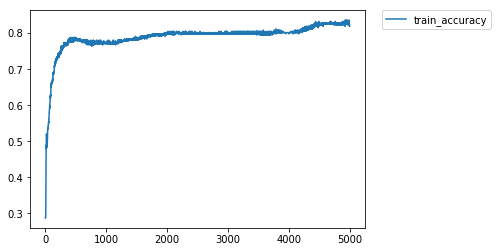

In [171]:
plt.plot(history.history['acc'], label = 'train_accuracy',)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

In [174]:
test_loss, test_acc = model.evaluate(test_pdf.drop('label', axis=1), test_onehot)

print('Test accuracy:', test_acc)

98/98 [==============================] - 0s 991us/step
Test accuracy: 0.7959183673469388


In [177]:
y_hat = model.predict(test_pdf.drop('label', axis=1))
y_hat = y_hat.argmax(axis=1)
y_hat = label_encoder.inverse_transform(y_hat)

Text(0, 0.5, 'predicted')

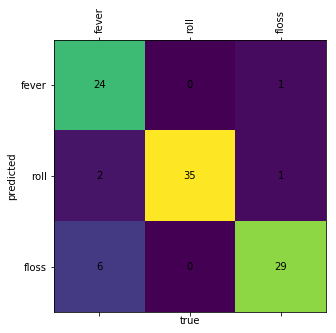

In [180]:
fig = plt.figure(figsize=(5,5))
ax = plt.subplot()

labels = list(test_pdf['label'].value_counts().index)

confusion = confusion_matrix(test_labels, test_pred, labels=labels)
ax.matshow(confusion)

ax.set_xticks(range(len(labels)))
ax.set_yticks(range(len(labels)))

ax.set_xticklabels(labels, rotation=90);
ax.set_yticklabels(labels);

for i in range(len(labels)):
    for j in range(len(labels)):        
        ax.text(j, i, confusion[i,j], va='center', ha='center')
        
plt.xlabel('true')
plt.ylabel('predicted')

In [181]:
print(classification_report(test_labels, test_pred, labels=labels))

              precision    recall  f1-score   support

       fever       0.75      0.96      0.84        25
        roll       1.00      0.92      0.96        38
       floss       0.94      0.83      0.88        35

   micro avg       0.90      0.90      0.90        98
   macro avg       0.90      0.90      0.89        98
weighted avg       0.91      0.90      0.90        98



### Save the best model

In [247]:
import os
from pathlib import Path
from datetime import datetime as dt

save =  False 
ver = int(dt.now().timestamp())

if save:
    for fmt in ['pb', 'hdf5', 'json']:
        # save model as hdf5
        MODEL_DIR = f"new_models/{fmt}"
        export_path = Path(MODEL_DIR, str(ver))

        if fmt == 'pb':
            # simple_save can not handle existing repository
            !rm -r {export_path}

            # Inspired by https://www.tensorflow.org/serving/tutorials/Serving_REST_simple
            # to save model for TF-serving
            tf.saved_model.simple_save(
                tf.keras.backend.get_session(),
                str(export_path),
                inputs={'input_data': model.input},
                outputs={t.name:t for t in model.outputs})
            
        elif fmt == 'hdf5':
            # make sure directory exists
            os.makedirs(export_path, exist_ok=True)
            
            model_path = Path(export_path, 'saved_model.h5') 
            
            # hdf5
            model.save(model_path)
            
        else:
            # make sure directory exists
            os.makedirs(export_path, exist_ok=True)
            
            # json
            model_spec_path = Path(
                export_path, 'saved_model_spec.json'
            )
            model_weights_path = Path(
                export_path, 'checkpoint')
            
            model_spec_path.write_text(model.to_json(), encoding='utf-8')
            model.save_weights(str(model_weights_path))

        print('\nSaved model:')
        !ls -l {export_path}